In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import os
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


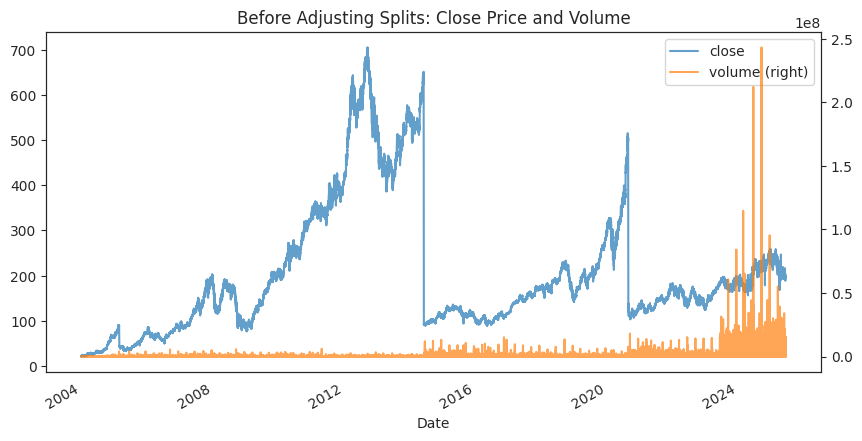

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


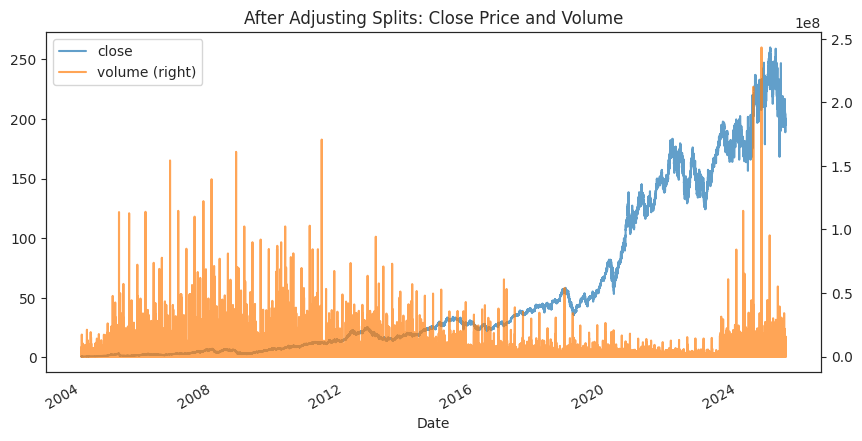

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = params.ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df: pd.DataFrame,
    min_prof_thr: float,
    max_down_prop: float,
    gain_tightening_factor: float,
    merging_retracement_thr: float,
    merging_time_gap_thr: float,
    tau_time: int,
    tau_dur: int,
    trailing_stop_pct: float,
    buy_threshold: float,
    smoothing_window: int
) -> float:
    """
    1) Run the full backtest pipeline to simulate trades and P&L per day.
    2) Extract each day’s performance stats (strategy return and trade returns).
    3) Free intermediate DataFrames and trade lists to minimize memory usage.
    4) Compute total and average daily P&L across all trading days.
    5) Compute total trades and average return per trade.
    6) Print a summary of P&L metrics.
    Returns the average daily P&L for Optuna’s objective.
    """
    # A) Execute the end-to-end trading simulation
    simulation = trades.run_trading_pipeline(
        df, 
        col_signal="signal",
        col_action="signal_action",
        min_prof_thr=min_prof_thr,
        max_down_prop=max_down_prop,
        gain_tightening_factor=gain_tightening_factor,
        merging_retracement_thr=merging_retracement_thr,
        merging_time_gap_thr=merging_time_gap_thr,
        tau_time=tau_time,
        tau_dur=tau_dur,
        trailing_stop_pct=trailing_stop_pct,
        buy_threshold=buy_threshold,
        smoothing_window=smoothing_window
    )
    
    # If pipeline returned None (no trading days), bail out
    if not simulation:
        return 0.0

    # B) Extract per-day performance stats from simulation output
    per_day_stats = [
        stats 
        for (_, (_, _, stats)) 
        in simulation.items()
    ]

    # C) Release DataFrames and trade lists to free memory
    for (_, (df_sim, trades_list, _)) in simulation.items():
        del df_sim, trades_list
    num_days = len(simulation)
    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # D) Compute total and average daily P&L
    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # E) Compute trade-level metrics: total trades and avg return per trade
    trades_only_days = [s for s in per_day_stats if s["Trades Returns ($)"]]
    total_trades     = sum(len(s["Trades Returns ($)"]) for s in trades_only_days)
    avg_per_trade    = (total_pnl / total_trades) if total_trades else 0.0

    # F) Print a summary of results
    print(f"→ Total P&L over {num_days} days   : ${total_pnl:.2f}")
    print(f"→ Avg daily P&L                    : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                     : {total_trades}")
    print(f"→ Avg return per trade            : ${avg_per_trade:.4f}\n")

    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.1), # increasing min, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 3),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 5, 50),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 1, 7),
        "tau_time"                : trial.suggest_int("tau_time", 1, 60),
        "tau_dur"                 : trial.suggest_int("tau_dur", 60, 240),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.1), # increasing min, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.1, 0.7),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [params.smooth_sign_win_tick])
    }

    print('---------------------------------------------------------------------------------------------------------------\n')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-09-09 22:04:06,643] A new study created in RDB with name: no-name-9225d874-d1c8-4589-8a7d-4d44362abcc8


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.859 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.76day/s]
[I 2025-09-09 22:07:10,834] Trial 0 finished with value: 0.46273370370370365 and parameters: {'min_prof_thr': 0.0535654419398297, 'max_down_prop': 0.3530622754600292, 'gain_tightening_factor': 22.857075202353666, 'merging_retracement_thr': 0.5780390510518433, 'merging_time_gap_thr': 5.375717687558304, 'tau_time': 23, 'tau_dur': 238, 'trailing_stop_pct': 0.07803294155890259, 'buy_threshold': 0.23382213760692305, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2498.76
→ Avg daily P&L                    : $0.4627
→ Total trades                     : 22160
→ Avg return per trade            : $0.1128



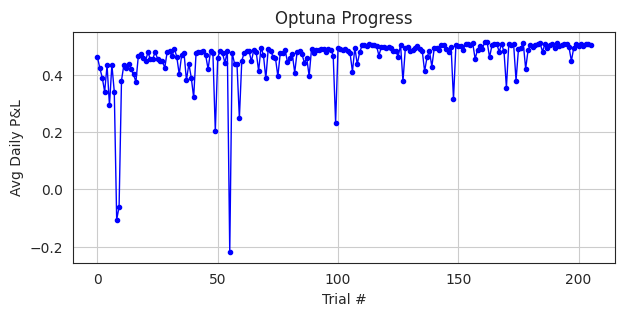

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.686 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.75day/s]
[I 2025-09-09 22:10:08,983] Trial 1 finished with value: 0.42347814814814816 and parameters: {'min_prof_thr': 0.04981076341638391, 'max_down_prop': 0.2746319499980514, 'gain_tightening_factor': 16.91097899507378, 'merging_retracement_thr': 0.5989306864772087, 'merging_time_gap_thr': 5.882469982388074, 'tau_time': 46, 'tau_dur': 139, 'trailing_stop_pct': 0.0897260246305045, 'buy_threshold': 0.4675830947121148, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2286.78
→ Avg daily P&L                    : $0.4235
→ Total trades                     : 11626
→ Avg return per trade            : $0.1967

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.395 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.55day/s]
[I 2025-09-09 22:13:17,615] Trial 2 finished with value: 0.3910422222222222 and parameters: {'min_prof_thr': 0.012878615343507838, 'max_down_prop': 0.532367459072862, 'gain_tightening_factor': 17.767459075209082, 'merging_retracement_thr': 0.4964837726380469, 'merging_time_gap_thr': 3.0514941966358786, 'tau_time': 58, 'tau_dur': 66, 'trailing_stop_pct': 0.09383308312773066, 'buy_threshold': 0.22617832404613708, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2111.63
→ Avg daily P&L                    : $0.3910
→ Total trades                     : 16108
→ Avg return per trade            : $0.1311

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.985 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.67day/s]
[I 2025-09-09 22:16:26,379] Trial 3 finished with value: 0.3413607407407407 and parameters: {'min_prof_thr': 0.037084904710738595, 'max_down_prop': 0.6163424463920084, 'gain_tightening_factor': 16.871945973426918, 'merging_retracement_thr': 0.3731772964669914, 'merging_time_gap_thr': 4.393655060496881, 'tau_time': 50, 'tau_dur': 195, 'trailing_stop_pct': 0.04996142657956961, 'buy_threshold': 0.12189919933438705, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $1843.35
→ Avg daily P&L                    : $0.3414
→ Total trades                     : 19490
→ Avg return per trade            : $0.0946

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.453 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.34day/s]
[I 2025-09-09 22:19:21,407] Trial 4 finished with value: 0.4336116666666667 and parameters: {'min_prof_thr': 0.09358090226338518, 'max_down_prop': 0.7741546991187366, 'gain_tightening_factor': 17.04587368945544, 'merging_retracement_thr': 0.6102887383547808, 'merging_time_gap_thr': 2.367188904835409, 'tau_time': 53, 'tau_dur': 148, 'trailing_stop_pct': 0.09761722280420468, 'buy_threshold': 0.2565533830282262, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2341.50
→ Avg daily P&L                    : $0.4336
→ Total trades                     : 14932
→ Avg return per trade            : $0.1568

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.767 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.52day/s]
[I 2025-09-09 22:22:19,512] Trial 5 finished with value: 0.2940205555555556 and parameters: {'min_prof_thr': 0.03323774786488224, 'max_down_prop': 0.9991530616195492, 'gain_tightening_factor': 13.146876295378052, 'merging_retracement_thr': 0.4303286251947074, 'merging_time_gap_thr': 1.7651843290351539, 'tau_time': 48, 'tau_dur': 206, 'trailing_stop_pct': 0.03926613065675029, 'buy_threshold': 0.6624612803919984, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $1587.71
→ Avg daily P&L                    : $0.2940
→ Total trades                     : 7210
→ Avg return per trade            : $0.2202

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.556 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.60day/s]
[I 2025-09-09 22:25:15,269] Trial 6 finished with value: 0.4362862962962963 and parameters: {'min_prof_thr': 0.08680568967067526, 'max_down_prop': 0.40412795335360574, 'gain_tightening_factor': 11.221859742211073, 'merging_retracement_thr': 0.9118391605101137, 'merging_time_gap_thr': 1.1120658482805899, 'tau_time': 26, 'tau_dur': 62, 'trailing_stop_pct': 0.08337560440735603, 'buy_threshold': 0.29395239885780133, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2355.95
→ Avg daily P&L                    : $0.4363
→ Total trades                     : 19163
→ Avg return per trade            : $0.1229

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.749 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.26day/s]
[I 2025-09-09 22:28:18,863] Trial 7 finished with value: 0.3418066666666667 and parameters: {'min_prof_thr': 0.05470709629097191, 'max_down_prop': 0.5447363221718567, 'gain_tightening_factor': 21.13626776476351, 'merging_retracement_thr': 0.7405927979211037, 'merging_time_gap_thr': 5.737022972934098, 'tau_time': 19, 'tau_dur': 182, 'trailing_stop_pct': 0.04946681122741105, 'buy_threshold': 0.13149273942713893, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $1845.76
→ Avg daily P&L                    : $0.3418
→ Total trades                     : 26518
→ Avg return per trade            : $0.0696

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.243 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.27day/s]
[I 2025-09-09 22:31:19,979] Trial 8 finished with value: -0.10600166666666666 and parameters: {'min_prof_thr': 0.04939230611860842, 'max_down_prop': 0.946516614352799, 'gain_tightening_factor': 17.480111566632996, 'merging_retracement_thr': 0.6020013911882989, 'merging_time_gap_thr': 1.6236004991962882, 'tau_time': 4, 'tau_dur': 111, 'trailing_stop_pct': 0.04737888638731659, 'buy_threshold': 0.18713839747240613, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $-572.41
→ Avg daily P&L                    : $-0.1060
→ Total trades                     : 43467
→ Avg return per trade            : $-0.0132

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.579 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.27day/s]
[I 2025-09-09 22:34:23,779] Trial 9 finished with value: -0.061073703703703706 and parameters: {'min_prof_thr': 0.054920752770342474, 'max_down_prop': 0.47787548405929925, 'gain_tightening_factor': 7.194140173278316, 'merging_retracement_thr': 0.24826928785193011, 'merging_time_gap_thr': 2.808324638535878, 'tau_time': 3, 'tau_dur': 218, 'trailing_stop_pct': 0.040099992672952695, 'buy_threshold': 0.20869911942898192, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $-329.80
→ Avg daily P&L                    : $-0.0611
→ Total trades                     : 46572
→ Avg return per trade            : $-0.0071

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.234 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.67day/s]
[I 2025-09-09 22:37:27,819] Trial 10 finished with value: 0.38058740740740743 and parameters: {'min_prof_thr': 0.07103360902762351, 'max_down_prop': 0.11853062098883216, 'gain_tightening_factor': 24.978796794177875, 'merging_retracement_thr': 0.12154394378289102, 'merging_time_gap_thr': 6.807240487751695, 'tau_time': 37, 'tau_dur': 239, 'trailing_stop_pct': 0.07114193840299525, 'buy_threshold': 0.4228886457982924, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2055.17
→ Avg daily P&L                    : $0.3806
→ Total trades                     : 13951
→ Avg return per trade            : $0.1473

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.319 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.86day/s]
[I 2025-09-09 22:40:28,475] Trial 11 finished with value: 0.4363911111111111 and parameters: {'min_prof_thr': 0.08163484435714856, 'max_down_prop': 0.35223036907506583, 'gain_tightening_factor': 10.687504812396359, 'merging_retracement_thr': 0.99372189766199, 'merging_time_gap_thr': 4.401150573091703, 'tau_time': 24, 'tau_dur': 66, 'trailing_stop_pct': 0.07660891294639499, 'buy_threshold': 0.3287538647620711, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2356.51
→ Avg daily P&L                    : $0.4364
→ Total trades                     : 19808
→ Avg return per trade            : $0.1190

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.116 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.66day/s]
[I 2025-09-09 22:43:24,217] Trial 12 finished with value: 0.42347481481481475 and parameters: {'min_prof_thr': 0.07735314795565358, 'max_down_prop': 0.28534540432367905, 'gain_tightening_factor': 8.303701482476683, 'merging_retracement_thr': 0.9981244170580976, 'merging_time_gap_thr': 4.290177317508243, 'tau_time': 17, 'tau_dur': 107, 'trailing_stop_pct': 0.07190962663915068, 'buy_threshold': 0.3464996960709821, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2286.76
→ Avg daily P&L                    : $0.4235
→ Total trades                     : 21116
→ Avg return per trade            : $0.1083

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.859 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.51day/s]
[I 2025-09-09 22:46:26,346] Trial 13 finished with value: 0.43690388888888887 and parameters: {'min_prof_thr': 0.07210399021173841, 'max_down_prop': 0.2890358684385168, 'gain_tightening_factor': 11.056663258692273, 'merging_retracement_thr': 0.7911796620395251, 'merging_time_gap_thr': 5.051872627623646, 'tau_time': 35, 'tau_dur': 169, 'trailing_stop_pct': 0.07950716679078901, 'buy_threshold': 0.5012976162759244, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2359.28
→ Avg daily P&L                    : $0.4369
→ Total trades                     : 12954
→ Avg return per trade            : $0.1821

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.846 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.07day/s]
[I 2025-09-09 22:49:24,546] Trial 14 finished with value: 0.41931740740740747 and parameters: {'min_prof_thr': 0.06825820840659048, 'max_down_prop': 0.12439099005402204, 'gain_tightening_factor': 5.173426813147753, 'merging_retracement_thr': 0.8117171062362637, 'merging_time_gap_thr': 5.4207003482456075, 'tau_time': 36, 'tau_dur': 168, 'trailing_stop_pct': 0.06008430875902862, 'buy_threshold': 0.5323021519361295, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2264.31
→ Avg daily P&L                    : $0.4193
→ Total trades                     : 12357
→ Avg return per trade            : $0.1832

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.684 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.00day/s]
[I 2025-09-09 22:52:22,794] Trial 15 finished with value: 0.4017755555555555 and parameters: {'min_prof_thr': 0.06489214021977016, 'max_down_prop': 0.21377245086748922, 'gain_tightening_factor': 24.91447843848401, 'merging_retracement_thr': 0.7434406041575597, 'merging_time_gap_thr': 4.996041422179098, 'tau_time': 37, 'tau_dur': 229, 'trailing_stop_pct': 0.06330142507478813, 'buy_threshold': 0.5791261774788168, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2169.59
→ Avg daily P&L                    : $0.4018
→ Total trades                     : 11086
→ Avg return per trade            : $0.1957

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 9.364 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.31day/s]
[I 2025-09-09 22:55:11,214] Trial 16 finished with value: 0.37609129629629634 and parameters: {'min_prof_thr': 0.09927970964621968, 'max_down_prop': 0.6329529170903099, 'gain_tightening_factor': 21.16741594616707, 'merging_retracement_thr': 0.7200345299572161, 'merging_time_gap_thr': 6.605939055751376, 'tau_time': 13, 'tau_dur': 167, 'trailing_stop_pct': 0.08291950325242002, 'buy_threshold': 0.49501968187059187, 'smoothing_window': 15}. Best is trial 0 with value: 0.46273370370370365.


→ Total P&L over 5400 days   : $2030.89
→ Avg daily P&L                    : $0.3761
→ Total trades                     : 19673
→ Avg return per trade            : $0.1032

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.049 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.82day/s]
[I 2025-09-09 22:58:00,536] Trial 17 finished with value: 0.46685351851851853 and parameters: {'min_prof_thr': 0.03573983701507975, 'max_down_prop': 0.33637628243233203, 'gain_tightening_factor': 14.222459638215955, 'merging_retracement_thr': 0.8301936208989737, 'merging_time_gap_thr': 3.573146470707245, 'tau_time': 32, 'tau_dur': 115, 'trailing_stop_pct': 0.08450500504291872, 'buy_threshold': 0.40455614049073985, 'smoothing_window': 15}. Best is trial 17 with value: 0.46685351851851853.


→ Total P&L over 5400 days   : $2521.01
→ Avg daily P&L                    : $0.4669
→ Total trades                     : 15284
→ Avg return per trade            : $0.1649

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.862 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.52day/s]
[I 2025-09-09 23:00:45,629] Trial 18 finished with value: 0.4736951851851852 and parameters: {'min_prof_thr': 0.03117086997451485, 'max_down_prop': 0.41905197815057804, 'gain_tightening_factor': 14.248763890398214, 'merging_retracement_thr': 0.8897669263584354, 'merging_time_gap_thr': 3.5361532531626283, 'tau_time': 27, 'tau_dur': 121, 'trailing_stop_pct': 0.08767314123401895, 'buy_threshold': 0.4011579270451641, 'smoothing_window': 15}. Best is trial 18 with value: 0.4736951851851852.


→ Total P&L over 5400 days   : $2557.95
→ Avg daily P&L                    : $0.4737
→ Total trades                     : 16406
→ Avg return per trade            : $0.1559

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.448 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.63day/s]
[I 2025-09-09 23:03:29,462] Trial 19 finished with value: 0.4594051851851852 and parameters: {'min_prof_thr': 0.01789758959275848, 'max_down_prop': 0.748895932873324, 'gain_tightening_factor': 14.065417871597221, 'merging_retracement_thr': 0.8847449557751015, 'merging_time_gap_thr': 3.4731916703533017, 'tau_time': 30, 'tau_dur': 117, 'trailing_stop_pct': 0.08972765509304817, 'buy_threshold': 0.3996806482805055, 'smoothing_window': 15}. Best is trial 18 with value: 0.4736951851851852.


→ Total P&L over 5400 days   : $2480.79
→ Avg daily P&L                    : $0.4594
→ Total trades                     : 15296
→ Avg return per trade            : $0.1622

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.986 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.19day/s]
[I 2025-09-09 23:06:31,777] Trial 20 finished with value: 0.45017444444444443 and parameters: {'min_prof_thr': 0.034706806366824994, 'max_down_prop': 0.4006950957380929, 'gain_tightening_factor': 14.994428953310454, 'merging_retracement_thr': 0.8873666296236106, 'merging_time_gap_thr': 3.691633100949235, 'tau_time': 43, 'tau_dur': 90, 'trailing_stop_pct': 0.09844819841093311, 'buy_threshold': 0.3929550820620763, 'smoothing_window': 15}. Best is trial 18 with value: 0.4736951851851852.


→ Total P&L over 5400 days   : $2430.94
→ Avg daily P&L                    : $0.4502
→ Total trades                     : 14111
→ Avg return per trade            : $0.1723

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.697 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.84day/s]
[I 2025-09-09 23:09:25,525] Trial 21 finished with value: 0.47922037037037035 and parameters: {'min_prof_thr': 0.02561761507277903, 'max_down_prop': 0.4321697827017868, 'gain_tightening_factor': 20.127774467442592, 'merging_retracement_thr': 0.6677958575212443, 'merging_time_gap_thr': 3.6284162356284737, 'tau_time': 24, 'tau_dur': 131, 'trailing_stop_pct': 0.0868400911177253, 'buy_threshold': 0.3289074515639546, 'smoothing_window': 15}. Best is trial 21 with value: 0.47922037037037035.


→ Total P&L over 5400 days   : $2587.79
→ Avg daily P&L                    : $0.4792
→ Total trades                     : 19115
→ Avg return per trade            : $0.1354

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.667 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.78day/s]
[I 2025-09-09 23:12:13,691] Trial 22 finished with value: 0.45552129629629623 and parameters: {'min_prof_thr': 0.024879619001565774, 'max_down_prop': 0.4573219324310577, 'gain_tightening_factor': 19.261274233044944, 'merging_retracement_thr': 0.6547464294216281, 'merging_time_gap_thr': 3.2116855644945845, 'tau_time': 12, 'tau_dur': 135, 'trailing_stop_pct': 0.08799485631699126, 'buy_threshold': 0.32881139844979373, 'smoothing_window': 15}. Best is trial 21 with value: 0.47922037037037035.


→ Total P&L over 5400 days   : $2459.81
→ Avg daily P&L                    : $0.4555
→ Total trades                     : 24965
→ Avg return per trade            : $0.0985

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.723 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.70day/s]
[I 2025-09-09 23:14:54,558] Trial 23 finished with value: 0.45644907407407415 and parameters: {'min_prof_thr': 0.025034357002728058, 'max_down_prop': 0.21257398814162673, 'gain_tightening_factor': 12.755376659493358, 'merging_retracement_thr': 0.8230985348862111, 'merging_time_gap_thr': 3.8737584322935614, 'tau_time': 31, 'tau_dur': 92, 'trailing_stop_pct': 0.07226325005939901, 'buy_threshold': 0.4471047395366703, 'smoothing_window': 15}. Best is trial 21 with value: 0.47922037037037035.


→ Total P&L over 5400 days   : $2464.83
→ Avg daily P&L                    : $0.4564
→ Total trades                     : 14318
→ Avg return per trade            : $0.1721

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.202 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.59day/s]
[I 2025-09-09 23:17:38,973] Trial 24 finished with value: 0.48038574074074075 and parameters: {'min_prof_thr': 0.04108732280775626, 'max_down_prop': 0.47036750060444354, 'gain_tightening_factor': 19.472202161182345, 'merging_retracement_thr': 0.688137796449577, 'merging_time_gap_thr': 2.5641209675312275, 'tau_time': 29, 'tau_dur': 122, 'trailing_stop_pct': 0.0849830296045205, 'buy_threshold': 0.3738545884176333, 'smoothing_window': 15}. Best is trial 24 with value: 0.48038574074074075.


→ Total P&L over 5400 days   : $2594.08
→ Avg daily P&L                    : $0.4804
→ Total trades                     : 16760
→ Avg return per trade            : $0.1548

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.137 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.81day/s]
[I 2025-09-09 23:20:24,076] Trial 25 finished with value: 0.457092962962963 and parameters: {'min_prof_thr': 0.04235676244692416, 'max_down_prop': 0.6913862912897157, 'gain_tightening_factor': 19.22652142584103, 'merging_retracement_thr': 0.6830030999270477, 'merging_time_gap_thr': 2.4800670623773144, 'tau_time': 41, 'tau_dur': 130, 'trailing_stop_pct': 0.09111802802351386, 'buy_threshold': 0.3567940344449286, 'smoothing_window': 15}. Best is trial 24 with value: 0.48038574074074075.


→ Total P&L over 5400 days   : $2468.30
→ Avg daily P&L                    : $0.4571
→ Total trades                     : 14741
→ Avg return per trade            : $0.1674

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.738 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.97day/s]
[I 2025-09-09 23:23:08,904] Trial 26 finished with value: 0.45051703703703705 and parameters: {'min_prof_thr': 0.02703219619147795, 'max_down_prop': 0.47698908208801294, 'gain_tightening_factor': 20.37164220739818, 'merging_retracement_thr': 0.5097512996949881, 'merging_time_gap_thr': 2.4693662238137586, 'tau_time': 27, 'tau_dur': 87, 'trailing_stop_pct': 0.09999669635879455, 'buy_threshold': 0.27999049510897905, 'smoothing_window': 15}. Best is trial 24 with value: 0.48038574074074075.


→ Total P&L over 5400 days   : $2432.79
→ Avg daily P&L                    : $0.4505
→ Total trades                     : 19687
→ Avg return per trade            : $0.1236

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.329 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.49day/s]
[I 2025-09-09 23:25:54,748] Trial 27 finished with value: 0.44746092592592596 and parameters: {'min_prof_thr': 0.045333689967108966, 'max_down_prop': 0.6028656094170721, 'gain_tightening_factor': 22.463899280130523, 'merging_retracement_thr': 0.4040328827210076, 'merging_time_gap_thr': 1.8419698945716894, 'tau_time': 19, 'tau_dur': 154, 'trailing_stop_pct': 0.05690458846349479, 'buy_threshold': 0.5663896363177366, 'smoothing_window': 15}. Best is trial 24 with value: 0.48038574074074075.


→ Total P&L over 5400 days   : $2416.29
→ Avg daily P&L                    : $0.4475
→ Total trades                     : 13949
→ Avg return per trade            : $0.1732

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.514 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.51day/s]
[I 2025-09-09 23:28:39,660] Trial 28 finished with value: 0.4252944444444445 and parameters: {'min_prof_thr': 0.018413956255888785, 'max_down_prop': 0.421086459298607, 'gain_tightening_factor': 18.946396379930942, 'merging_retracement_thr': 0.6581460267783716, 'merging_time_gap_thr': 2.7168232805258845, 'tau_time': 9, 'tau_dur': 126, 'trailing_stop_pct': 0.06845550513173636, 'buy_threshold': 0.30024911590330666, 'smoothing_window': 15}. Best is trial 24 with value: 0.48038574074074075.


→ Total P&L over 5400 days   : $2296.59
→ Avg daily P&L                    : $0.4253
→ Total trades                     : 29016
→ Avg return per trade            : $0.0791

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.787 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:21<00:00, 38.14day/s]
[I 2025-09-09 23:31:23,700] Trial 29 finished with value: 0.4815822222222222 and parameters: {'min_prof_thr': 0.02881374627974577, 'max_down_prop': 0.5124656632634245, 'gain_tightening_factor': 23.0429148341289, 'merging_retracement_thr': 0.5423683470349153, 'merging_time_gap_thr': 4.094812268493499, 'tau_time': 21, 'tau_dur': 101, 'trailing_stop_pct': 0.07875687616657787, 'buy_threshold': 0.3708921322132564, 'smoothing_window': 15}. Best is trial 29 with value: 0.4815822222222222.


→ Total P&L over 5400 days   : $2600.54
→ Avg daily P&L                    : $0.4816
→ Total trades                     : 18895
→ Avg return per trade            : $0.1376

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.822 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.95day/s]
[I 2025-09-09 23:34:01,945] Trial 30 finished with value: 0.4843287037037036 and parameters: {'min_prof_thr': 0.06035931974900646, 'max_down_prop': 0.8246629142429619, 'gain_tightening_factor': 23.11603266960038, 'merging_retracement_thr': 0.5276586618823594, 'merging_time_gap_thr': 4.784798859706948, 'tau_time': 21, 'tau_dur': 99, 'trailing_stop_pct': 0.07746816864018828, 'buy_threshold': 0.3559153582454678, 'smoothing_window': 15}. Best is trial 30 with value: 0.4843287037037036.


→ Total P&L over 5400 days   : $2615.37
→ Avg daily P&L                    : $0.4843
→ Total trades                     : 19903
→ Avg return per trade            : $0.1314

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.911 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.30day/s]
[I 2025-09-09 23:36:40,365] Trial 31 finished with value: 0.46467407407407413 and parameters: {'min_prof_thr': 0.06266507647927107, 'max_down_prop': 0.8569266964232874, 'gain_tightening_factor': 23.177251297290294, 'merging_retracement_thr': 0.5106125714325096, 'merging_time_gap_thr': 4.121144291855869, 'tau_time': 21, 'tau_dur': 102, 'trailing_stop_pct': 0.07898508792175087, 'buy_threshold': 0.2672641002334251, 'smoothing_window': 15}. Best is trial 30 with value: 0.4843287037037036.


→ Total P&L over 5400 days   : $2509.24
→ Avg daily P&L                    : $0.4647
→ Total trades                     : 22484
→ Avg return per trade            : $0.1116

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.144 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.79day/s]
[I 2025-09-09 23:39:17,167] Trial 32 finished with value: 0.4924124074074073 and parameters: {'min_prof_thr': 0.03954226696237198, 'max_down_prop': 0.5241744159836232, 'gain_tightening_factor': 23.223725774007573, 'merging_retracement_thr': 0.5625252316295427, 'merging_time_gap_thr': 4.791809609418202, 'tau_time': 16, 'tau_dur': 95, 'trailing_stop_pct': 0.07637461840598168, 'buy_threshold': 0.3685278185183128, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2659.03
→ Avg daily P&L                    : $0.4924
→ Total trades                     : 21682
→ Avg return per trade            : $0.1226

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.014 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.56day/s]
[I 2025-09-09 23:41:56,348] Trial 33 finished with value: 0.46247611111111114 and parameters: {'min_prof_thr': 0.0593003466393009, 'max_down_prop': 0.5248679847897889, 'gain_tightening_factor': 23.2731397475461, 'merging_retracement_thr': 0.5504333928655083, 'merging_time_gap_thr': 4.755479019540379, 'tau_time': 14, 'tau_dur': 78, 'trailing_stop_pct': 0.07582945953894385, 'buy_threshold': 0.3722137918310998, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2497.37
→ Avg daily P&L                    : $0.4625
→ Total trades                     : 23297
→ Avg return per trade            : $0.1072

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.118 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.69day/s]
[I 2025-09-09 23:44:36,863] Trial 34 finished with value: 0.40210814814814816 and parameters: {'min_prof_thr': 0.04026738016521923, 'max_down_prop': 0.6415673378242952, 'gain_tightening_factor': 22.11160602529032, 'merging_retracement_thr': 0.46013958959032764, 'merging_time_gap_thr': 6.159334743135873, 'tau_time': 8, 'tau_dur': 101, 'trailing_stop_pct': 0.067980954347732, 'buy_threshold': 0.44715126015865553, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2171.38
→ Avg daily P&L                    : $0.4021
→ Total trades                     : 23957
→ Avg return per trade            : $0.0906

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.45 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.79day/s]
[I 2025-09-09 23:47:18,293] Trial 35 finished with value: 0.4693027777777778 and parameters: {'min_prof_thr': 0.047407856965560456, 'max_down_prop': 0.5718416826948393, 'gain_tightening_factor': 24.06303414444231, 'merging_retracement_thr': 0.3414545276595641, 'merging_time_gap_thr': 5.39426565393391, 'tau_time': 17, 'tau_dur': 78, 'trailing_stop_pct': 0.08060128440885171, 'buy_threshold': 0.46632275444867766, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2534.24
→ Avg daily P&L                    : $0.4693
→ Total trades                     : 17706
→ Avg return per trade            : $0.1431

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.106 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.16day/s]
[I 2025-09-09 23:49:58,664] Trial 36 finished with value: 0.47618111111111117 and parameters: {'min_prof_thr': 0.040758863341914836, 'max_down_prop': 0.6969191373855415, 'gain_tightening_factor': 21.771360691646596, 'merging_retracement_thr': 0.5662719092740709, 'merging_time_gap_thr': 4.640300852434733, 'tau_time': 22, 'tau_dur': 78, 'trailing_stop_pct': 0.09464591057564929, 'buy_threshold': 0.37381517793398206, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2571.38
→ Avg daily P&L                    : $0.4762
→ Total trades                     : 19033
→ Avg return per trade            : $0.1351

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.389 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.64day/s]
[I 2025-09-09 23:52:46,028] Trial 37 finished with value: 0.3812605555555555 and parameters: {'min_prof_thr': 0.012028961791367879, 'max_down_prop': 0.5082369362349528, 'gain_tightening_factor': 23.606843477145027, 'merging_retracement_thr': 0.3208453803305972, 'merging_time_gap_thr': 4.716131693865172, 'tau_time': 7, 'tau_dur': 97, 'trailing_stop_pct': 0.07361820326080593, 'buy_threshold': 0.29900409061574124, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2058.81
→ Avg daily P&L                    : $0.3813
→ Total trades                     : 30513
→ Avg return per trade            : $0.0675

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.714 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.18day/s]
[I 2025-09-09 23:55:25,641] Trial 38 finished with value: 0.43909981481481475 and parameters: {'min_prof_thr': 0.05909034929097387, 'max_down_prop': 0.8522902049303241, 'gain_tightening_factor': 20.344226509833018, 'merging_retracement_thr': 0.4707490862320009, 'merging_time_gap_thr': 5.958514883123218, 'tau_time': 16, 'tau_dur': 152, 'trailing_stop_pct': 0.06395878424319752, 'buy_threshold': 0.23041973641736607, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2371.14
→ Avg daily P&L                    : $0.4391
→ Total trades                     : 26077
→ Avg return per trade            : $0.0909

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.816 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.89day/s]
[I 2025-09-09 23:58:09,805] Trial 39 finished with value: 0.39112296296296295 and parameters: {'min_prof_thr': 0.0310243685575107, 'max_down_prop': 0.5699737661485142, 'gain_tightening_factor': 16.67021813806519, 'merging_retracement_thr': 0.5947611130875873, 'merging_time_gap_thr': 4.022980171302483, 'tau_time': 28, 'tau_dur': 86, 'trailing_stop_pct': 0.08285348806097807, 'buy_threshold': 0.1795773956952281, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2112.06
→ Avg daily P&L                    : $0.3911
→ Total trades                     : 22873
→ Avg return per trade            : $0.0923

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.418 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.75day/s]
[I 2025-09-10 00:00:47,191] Trial 40 finished with value: 0.32143777777777777 and parameters: {'min_prof_thr': 0.052381802141215836, 'max_down_prop': 0.8482398763282193, 'gain_tightening_factor': 18.27405935475486, 'merging_retracement_thr': 0.5346400477363841, 'merging_time_gap_thr': 3.1554962273830163, 'tau_time': 54, 'tau_dur': 142, 'trailing_stop_pct': 0.09190413241915042, 'buy_threshold': 0.6923248088877464, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $1735.76
→ Avg daily P&L                    : $0.3214
→ Total trades                     : 7023
→ Avg return per trade            : $0.2472

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.557 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.35day/s]
[I 2025-09-10 00:03:29,183] Trial 41 finished with value: 0.4775605555555555 and parameters: {'min_prof_thr': 0.02055385662700526, 'max_down_prop': 0.46313910414515563, 'gain_tightening_factor': 20.251553512951478, 'merging_retracement_thr': 0.6482727037897473, 'merging_time_gap_thr': 5.125129902255181, 'tau_time': 22, 'tau_dur': 107, 'trailing_stop_pct': 0.08540801086524627, 'buy_threshold': 0.32297139801506014, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2578.83
→ Avg daily P&L                    : $0.4776
→ Total trades                     : 19914
→ Avg return per trade            : $0.1295

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.35 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.08day/s]
[I 2025-09-10 00:06:07,470] Trial 42 finished with value: 0.48210185185185184 and parameters: {'min_prof_thr': 0.04483561090514891, 'max_down_prop': 0.5117776047003234, 'gain_tightening_factor': 21.483944361807648, 'merging_retracement_thr': 0.6262846753413605, 'merging_time_gap_thr': 2.1119453779190245, 'tau_time': 24, 'tau_dur': 127, 'trailing_stop_pct': 0.07622291566739955, 'buy_threshold': 0.43099914692244284, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2603.35
→ Avg daily P&L                    : $0.4821
→ Total trades                     : 16436
→ Avg return per trade            : $0.1584

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.586 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.86day/s]
[I 2025-09-10 00:08:42,856] Trial 43 finished with value: 0.4813290740740741 and parameters: {'min_prof_thr': 0.05005336978732742, 'max_down_prop': 0.5034610228458751, 'gain_tightening_factor': 24.142974674041646, 'merging_retracement_thr': 0.614767895575117, 'merging_time_gap_thr': 2.0944241270065604, 'tau_time': 20, 'tau_dur': 122, 'trailing_stop_pct': 0.07594481208376944, 'buy_threshold': 0.4299992343368443, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2599.18
→ Avg daily P&L                    : $0.4813
→ Total trades                     : 17954
→ Avg return per trade            : $0.1448

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.581 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.37day/s]
[I 2025-09-10 00:11:23,247] Trial 44 finished with value: 0.4835818518518519 and parameters: {'min_prof_thr': 0.05031125843202132, 'max_down_prop': 0.5330044846856269, 'gain_tightening_factor': 24.38604183829046, 'merging_retracement_thr': 0.61095112797527, 'merging_time_gap_thr': 1.0350664428040561, 'tau_time': 19, 'tau_dur': 110, 'trailing_stop_pct': 0.07530769925008592, 'buy_threshold': 0.4321636529330186, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2611.34
→ Avg daily P&L                    : $0.4836
→ Total trades                     : 18272
→ Avg return per trade            : $0.1429

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.874 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 40.00day/s]
[I 2025-09-10 00:13:59,258] Trial 45 finished with value: 0.46838648148148143 and parameters: {'min_prof_thr': 0.059064408732921105, 'max_down_prop': 0.6740925476740637, 'gain_tightening_factor': 22.641526807175087, 'merging_retracement_thr': 0.42727922373157035, 'merging_time_gap_thr': 1.0397651820235085, 'tau_time': 25, 'tau_dur': 111, 'trailing_stop_pct': 0.06676809999822515, 'buy_threshold': 0.48933200165902774, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2529.29
→ Avg daily P&L                    : $0.4684
→ Total trades                     : 14699
→ Avg return per trade            : $0.1721

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.272 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.51day/s]
[I 2025-09-10 00:16:36,232] Trial 46 finished with value: 0.4205898148148149 and parameters: {'min_prof_thr': 0.04393300817032115, 'max_down_prop': 0.5812672565079929, 'gain_tightening_factor': 21.423596821404942, 'merging_retracement_thr': 0.5715964931979124, 'merging_time_gap_thr': 1.6157781563373832, 'tau_time': 11, 'tau_dur': 143, 'trailing_stop_pct': 0.07490996230693055, 'buy_threshold': 0.5352660874270396, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2271.19
→ Avg daily P&L                    : $0.4206
→ Total trades                     : 18760
→ Avg return per trade            : $0.1211

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.027 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.65day/s]
[I 2025-09-10 00:19:14,999] Trial 47 finished with value: 0.4829266666666666 and parameters: {'min_prof_thr': 0.038335077259153076, 'max_down_prop': 0.7529358902579144, 'gain_tightening_factor': 24.91997176769553, 'merging_retracement_thr': 0.6234345956455588, 'merging_time_gap_thr': 1.4354439747057381, 'tau_time': 15, 'tau_dur': 69, 'trailing_stop_pct': 0.06957175266899093, 'buy_threshold': 0.43332272149443146, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2607.80
→ Avg daily P&L                    : $0.4829
→ Total trades                     : 20312
→ Avg return per trade            : $0.1284

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.51 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.55day/s]
[I 2025-09-10 00:21:52,060] Trial 48 finished with value: 0.4758872222222222 and parameters: {'min_prof_thr': 0.052218490535224434, 'max_down_prop': 0.8023117863810132, 'gain_tightening_factor': 24.87364098649986, 'merging_retracement_thr': 0.6157500627170609, 'merging_time_gap_thr': 1.3179962221315167, 'tau_time': 16, 'tau_dur': 60, 'trailing_stop_pct': 0.07002113966403203, 'buy_threshold': 0.427986587205278, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2569.79
→ Avg daily P&L                    : $0.4759
→ Total trades                     : 20481
→ Avg return per trade            : $0.1255

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.981 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.70day/s]
[I 2025-09-10 00:24:29,653] Trial 49 finished with value: 0.20252111111111107 and parameters: {'min_prof_thr': 0.03877957978492223, 'max_down_prop': 0.9400684748251881, 'gain_tightening_factor': 24.186302690961202, 'merging_retracement_thr': 0.7569733194254508, 'merging_time_gap_thr': 1.3641734215391885, 'tau_time': 5, 'tau_dur': 71, 'trailing_stop_pct': 0.057577705796091304, 'buy_threshold': 0.4686491228599665, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $1093.61
→ Avg daily P&L                    : $0.2025
→ Total trades                     : 26792
→ Avg return per trade            : $0.0408

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.301 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.89day/s]
[I 2025-09-10 00:27:08,946] Trial 50 finished with value: 0.4609437037037038 and parameters: {'min_prof_thr': 0.04683356506000813, 'max_down_prop': 0.748938597120527, 'gain_tightening_factor': 22.019934242923252, 'merging_retracement_thr': 0.7124764626400306, 'merging_time_gap_thr': 2.006337138308533, 'tau_time': 18, 'tau_dur': 73, 'trailing_stop_pct': 0.06481867349075421, 'buy_threshold': 0.5278498951086528, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2489.10
→ Avg daily P&L                    : $0.4609
→ Total trades                     : 16326
→ Avg return per trade            : $0.1525

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.824 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.69day/s]
[I 2025-09-10 00:29:46,899] Trial 51 finished with value: 0.48477018518518517 and parameters: {'min_prof_thr': 0.030223902218556788, 'max_down_prop': 0.5279020984418784, 'gain_tightening_factor': 22.822694705525468, 'merging_retracement_thr': 0.5127649618485374, 'merging_time_gap_thr': 1.4013394328441644, 'tau_time': 14, 'tau_dur': 101, 'trailing_stop_pct': 0.08027121524529258, 'buy_threshold': 0.41924486894040064, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2617.76
→ Avg daily P&L                    : $0.4848
→ Total trades                     : 20358
→ Avg return per trade            : $0.1286

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.084 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.54day/s]
[I 2025-09-10 00:32:32,205] Trial 52 finished with value: 0.47561351851851846 and parameters: {'min_prof_thr': 0.037947767975840645, 'max_down_prop': 0.5462675764255553, 'gain_tightening_factor': 23.961927771820065, 'merging_retracement_thr': 0.4927055597395333, 'merging_time_gap_thr': 1.3822151016805968, 'tau_time': 14, 'tau_dur': 84, 'trailing_stop_pct': 0.0811926170720272, 'buy_threshold': 0.46511806036289366, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2568.31
→ Avg daily P&L                    : $0.4756
→ Total trades                     : 19206
→ Avg return per trade            : $0.1337

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.629 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:21<00:00, 38.13day/s]
[I 2025-09-10 00:35:14,540] Trial 53 finished with value: 0.4426111111111111 and parameters: {'min_prof_thr': 0.05626953617838501, 'max_down_prop': 0.9108101976485344, 'gain_tightening_factor': 24.6109332397735, 'merging_retracement_thr': 0.6214831765938279, 'merging_time_gap_thr': 1.582722141876157, 'tau_time': 10, 'tau_dur': 94, 'trailing_stop_pct': 0.030107376966399972, 'buy_threshold': 0.41556072236690067, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2390.10
→ Avg daily P&L                    : $0.4426
→ Total trades                     : 24284
→ Avg return per trade            : $0.0984

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.981 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.35day/s]
[I 2025-09-10 00:38:01,455] Trial 54 finished with value: 0.4837224074074074 and parameters: {'min_prof_thr': 0.03347808078340988, 'max_down_prop': 0.38161857507817676, 'gain_tightening_factor': 20.962038931409126, 'merging_retracement_thr': 0.4770148021983617, 'merging_time_gap_thr': 2.1861809026371795, 'tau_time': 15, 'tau_dur': 108, 'trailing_stop_pct': 0.07762893977489527, 'buy_threshold': 0.44170334492066193, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2612.10
→ Avg daily P&L                    : $0.4837
→ Total trades                     : 18991
→ Avg return per trade            : $0.1375

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.005 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.72day/s]
[I 2025-09-10 00:40:47,645] Trial 55 finished with value: -0.21979592592592595 and parameters: {'min_prof_thr': 0.03336882025649068, 'max_down_prop': 0.32471109521411745, 'gain_tightening_factor': 22.725925831767245, 'merging_retracement_thr': 0.4580234257692819, 'merging_time_gap_thr': 1.0203147938671564, 'tau_time': 1, 'tau_dur': 113, 'trailing_stop_pct': 0.061438351456381234, 'buy_threshold': 0.510807024534636, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $-1186.90
→ Avg daily P&L                    : $-0.2198
→ Total trades                     : 34521
→ Avg return per trade            : $-0.0344

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.074 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.47day/s]
[I 2025-09-10 00:43:32,049] Trial 56 finished with value: 0.47753388888888887 and parameters: {'min_prof_thr': 0.035993174909368555, 'max_down_prop': 0.39276761407756866, 'gain_tightening_factor': 23.44787390203166, 'merging_retracement_thr': 0.35759909515693, 'merging_time_gap_thr': 1.267333806871174, 'tau_time': 15, 'tau_dur': 66, 'trailing_stop_pct': 0.07074040239510741, 'buy_threshold': 0.3892267941725337, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2578.68
→ Avg daily P&L                    : $0.4775
→ Total trades                     : 21045
→ Avg return per trade            : $0.1225

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.22 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.18day/s]
[I 2025-09-10 00:46:11,495] Trial 57 finished with value: 0.43913814814814817 and parameters: {'min_prof_thr': 0.06781533929067707, 'max_down_prop': 0.7997497211907143, 'gain_tightening_factor': 24.949007729631806, 'merging_retracement_thr': 0.38763528502813627, 'merging_time_gap_thr': 1.8661880310637469, 'tau_time': 12, 'tau_dur': 107, 'trailing_stop_pct': 0.07790687531392144, 'buy_threshold': 0.3514363833823259, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2371.35
→ Avg daily P&L                    : $0.4391
→ Total trades                     : 24762
→ Avg return per trade            : $0.0958

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.581 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.47day/s]
[I 2025-09-10 00:48:52,088] Trial 58 finished with value: 0.43871314814814816 and parameters: {'min_prof_thr': 0.02270818148698061, 'max_down_prop': 0.6525873747634163, 'gain_tightening_factor': 20.96079317989134, 'merging_retracement_thr': 0.24948553015579833, 'merging_time_gap_thr': 2.206871597263725, 'tau_time': 18, 'tau_dur': 200, 'trailing_stop_pct': 0.07320204918718425, 'buy_threshold': 0.4544820223776993, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2369.05
→ Avg daily P&L                    : $0.4387
→ Total trades                     : 15808
→ Avg return per trade            : $0.1499

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.733 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.06day/s]
[I 2025-09-10 00:51:27,302] Trial 59 finished with value: 0.2490609259259259 and parameters: {'min_prof_thr': 0.029852976983837615, 'max_down_prop': 0.7398548450510319, 'gain_tightening_factor': 16.186194610180973, 'merging_retracement_thr': 0.5841820476401213, 'merging_time_gap_thr': 1.5483556190450727, 'tau_time': 5, 'tau_dur': 81, 'trailing_stop_pct': 0.06647466831059833, 'buy_threshold': 0.4778204462615643, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $1344.93
→ Avg daily P&L                    : $0.2491
→ Total trades                     : 25605
→ Avg return per trade            : $0.0525

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.375 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.81day/s]
[I 2025-09-10 00:54:01,091] Trial 60 finished with value: 0.4495651851851852 and parameters: {'min_prof_thr': 0.07896834550139128, 'max_down_prop': 0.37970879611901454, 'gain_tightening_factor': 22.471156639381277, 'merging_retracement_thr': 0.4388985490322898, 'merging_time_gap_thr': 4.412812488979784, 'tau_time': 13, 'tau_dur': 98, 'trailing_stop_pct': 0.0694503898572216, 'buy_threshold': 0.40453015916852675, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2427.65
→ Avg daily P&L                    : $0.4496
→ Total trades                     : 22820
→ Avg return per trade            : $0.1064

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.275 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.43day/s]
[I 2025-09-10 00:56:41,420] Trial 61 finished with value: 0.4778792592592592 and parameters: {'min_prof_thr': 0.0443856690849954, 'max_down_prop': 0.6148412870657775, 'gain_tightening_factor': 21.166868796971478, 'merging_retracement_thr': 0.6324986253983802, 'merging_time_gap_thr': 2.937733456181828, 'tau_time': 24, 'tau_dur': 118, 'trailing_stop_pct': 0.07699252186103753, 'buy_threshold': 0.4328386104290492, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2580.55
→ Avg daily P&L                    : $0.4779
→ Total trades                     : 16458
→ Avg return per trade            : $0.1568

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.894 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.87day/s]
[I 2025-09-10 00:59:18,085] Trial 62 finished with value: 0.4843248148148149 and parameters: {'min_prof_thr': 0.03289930262909834, 'max_down_prop': 0.5966451836420407, 'gain_tightening_factor': 21.883340513701988, 'merging_retracement_thr': 0.5125758155501993, 'merging_time_gap_thr': 2.326568446965298, 'tau_time': 18, 'tau_dur': 93, 'trailing_stop_pct': 0.07353305811015994, 'buy_threshold': 0.44225767850803344, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2615.35
→ Avg daily P&L                    : $0.4843
→ Total trades                     : 17911
→ Avg return per trade            : $0.1460

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.918 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.42day/s]
[I 2025-09-10 01:02:00,852] Trial 63 finished with value: 0.48436888888888885 and parameters: {'min_prof_thr': 0.03473016272725923, 'max_down_prop': 0.7246651629220879, 'gain_tightening_factor': 23.536500124763464, 'merging_retracement_thr': 0.5120691401893852, 'merging_time_gap_thr': 2.2971801886709815, 'tau_time': 20, 'tau_dur': 92, 'trailing_stop_pct': 0.08120990884049792, 'buy_threshold': 0.34023051834332996, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2615.59
→ Avg daily P&L                    : $0.4844
→ Total trades                     : 20354
→ Avg return per trade            : $0.1285

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.438 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.42day/s]
[I 2025-09-10 01:04:42,546] Trial 64 finished with value: 0.44729351851851856 and parameters: {'min_prof_thr': 0.015339027663256014, 'max_down_prop': 0.6020462213097477, 'gain_tightening_factor': 23.554485893919246, 'merging_retracement_thr': 0.4925875250962194, 'merging_time_gap_thr': 2.7367156548198897, 'tau_time': 33, 'tau_dur': 91, 'trailing_stop_pct': 0.0818712114252335, 'buy_threshold': 0.3466602310257747, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2415.39
→ Avg daily P&L                    : $0.4473
→ Total trades                     : 15887
→ Avg return per trade            : $0.1520

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.065 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:21<00:00, 38.09day/s]
[I 2025-09-10 01:07:26,847] Trial 65 finished with value: 0.4887785185185185 and parameters: {'min_prof_thr': 0.0341414176074124, 'max_down_prop': 0.23321546311345304, 'gain_tightening_factor': 20.736511707020355, 'merging_retracement_thr': 0.5293389371455567, 'merging_time_gap_thr': 2.2536671523593936, 'tau_time': 18, 'tau_dur': 105, 'trailing_stop_pct': 0.07355823837864515, 'buy_threshold': 0.3159120054539537, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2639.40
→ Avg daily P&L                    : $0.4888
→ Total trades                     : 22175
→ Avg return per trade            : $0.1190

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.087 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.50day/s]
[I 2025-09-10 01:10:08,950] Trial 66 finished with value: 0.48003333333333337 and parameters: {'min_prof_thr': 0.03421316154201599, 'max_down_prop': 0.18985571852738392, 'gain_tightening_factor': 20.88213575939485, 'merging_retracement_thr': 0.5204547718072499, 'merging_time_gap_thr': 2.2472262856608785, 'tau_time': 20, 'tau_dur': 104, 'trailing_stop_pct': 0.08062769021248903, 'buy_threshold': 0.31415770055461945, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2592.18
→ Avg daily P&L                    : $0.4800
→ Total trades                     : 21215
→ Avg return per trade            : $0.1222

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.793 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.00day/s]
[I 2025-09-10 01:12:53,526] Trial 67 finished with value: 0.41440296296296303 and parameters: {'min_prof_thr': 0.027445889430302732, 'max_down_prop': 0.3090003930670114, 'gain_tightening_factor': 18.58838034269969, 'merging_retracement_thr': 0.41785075018185097, 'merging_time_gap_thr': 3.358986274826611, 'tau_time': 12, 'tau_dur': 94, 'trailing_stop_pct': 0.0837416626753053, 'buy_threshold': 0.2660090185646671, 'smoothing_window': 15}. Best is trial 32 with value: 0.4924124074074073.


→ Total P&L over 5400 days   : $2237.78
→ Avg daily P&L                    : $0.4144
→ Total trades                     : 27579
→ Avg return per trade            : $0.0811

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.965 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.51day/s]
[I 2025-09-10 01:15:32,768] Trial 68 finished with value: 0.4956987037037037 and parameters: {'min_prof_thr': 0.031674707816944134, 'max_down_prop': 0.2681166948079611, 'gain_tightening_factor': 19.878770308746578, 'merging_retracement_thr': 0.47525865479461665, 'merging_time_gap_thr': 2.3918279788072465, 'tau_time': 16, 'tau_dur': 88, 'trailing_stop_pct': 0.07216139400142343, 'buy_threshold': 0.38807135463874814, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2676.77
→ Avg daily P&L                    : $0.4957
→ Total trades                     : 20609
→ Avg return per trade            : $0.1299

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.692 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.83day/s]
[I 2025-09-10 01:18:15,863] Trial 69 finished with value: 0.46959222222222224 and parameters: {'min_prof_thr': 0.02391053984001761, 'max_down_prop': 0.2636598435011167, 'gain_tightening_factor': 19.674405097103897, 'merging_retracement_thr': 0.5526696068605944, 'merging_time_gap_thr': 2.9701868336108936, 'tau_time': 26, 'tau_dur': 87, 'trailing_stop_pct': 0.07242490544342345, 'buy_threshold': 0.34135383002975556, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2535.80
→ Avg daily P&L                    : $0.4696
→ Total trades                     : 18346
→ Avg return per trade            : $0.1382

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.642 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.08day/s]
[I 2025-09-10 01:21:00,220] Trial 70 finished with value: 0.3880583333333334 and parameters: {'min_prof_thr': 0.021925704259454466, 'max_down_prop': 0.24519155857318506, 'gain_tightening_factor': 22.114976468518712, 'merging_retracement_thr': 0.5252616765913796, 'merging_time_gap_thr': 5.588439211232787, 'tau_time': 10, 'tau_dur': 74, 'trailing_stop_pct': 0.07364345711908934, 'buy_threshold': 0.24560497688106336, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2095.52
→ Avg daily P&L                    : $0.3881
→ Total trades                     : 30928
→ Avg return per trade            : $0.0678

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.004 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.31day/s]
[I 2025-09-10 01:23:44,390] Trial 71 finished with value: 0.4919392592592593 and parameters: {'min_prof_thr': 0.0316284635237814, 'max_down_prop': 0.16672278659123152, 'gain_tightening_factor': 20.67094021997603, 'merging_retracement_thr': 0.4786526039939985, 'merging_time_gap_thr': 2.3922727017180616, 'tau_time': 16, 'tau_dur': 98, 'trailing_stop_pct': 0.07908038805840775, 'buy_threshold': 0.3839387016589457, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2656.47
→ Avg daily P&L                    : $0.4919
→ Total trades                     : 20684
→ Avg return per trade            : $0.1284

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.932 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.63day/s]
[I 2025-09-10 01:26:26,949] Trial 72 finished with value: 0.4851451851851851 and parameters: {'min_prof_thr': 0.029738100975734014, 'max_down_prop': 0.15588349890476744, 'gain_tightening_factor': 22.783507381227725, 'merging_retracement_thr': 0.44642883215807694, 'merging_time_gap_thr': 2.368432346591909, 'tau_time': 17, 'tau_dur': 97, 'trailing_stop_pct': 0.08664392780057274, 'buy_threshold': 0.38522071069002645, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2619.78
→ Avg daily P&L                    : $0.4851
→ Total trades                     : 19918
→ Avg return per trade            : $0.1315

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.912 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.45day/s]
[I 2025-09-10 01:29:09,861] Trial 73 finished with value: 0.4637877777777778 and parameters: {'min_prof_thr': 0.029214618516747302, 'max_down_prop': 0.15809750737361764, 'gain_tightening_factor': 22.993691670620827, 'merging_retracement_thr': 0.4537525067761319, 'merging_time_gap_thr': 1.9366469385676885, 'tau_time': 17, 'tau_dur': 100, 'trailing_stop_pct': 0.0876140805174287, 'buy_threshold': 0.3101895628025819, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2504.45
→ Avg daily P&L                    : $0.4638
→ Total trades                     : 22395
→ Avg return per trade            : $0.1118

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.8 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.31day/s]
[I 2025-09-10 01:31:52,832] Trial 74 finished with value: 0.45912129629629633 and parameters: {'min_prof_thr': 0.026448451655665214, 'max_down_prop': 0.15192743958089605, 'gain_tightening_factor': 9.585583653343267, 'merging_retracement_thr': 0.30266501009796504, 'merging_time_gap_thr': 2.6049842538765304, 'tau_time': 22, 'tau_dur': 84, 'trailing_stop_pct': 0.07943508500303262, 'buy_threshold': 0.364431935821148, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2479.26
→ Avg daily P&L                    : $0.4591
→ Total trades                     : 17995
→ Avg return per trade            : $0.1378

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.204 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.41day/s]
[I 2025-09-10 01:34:32,966] Trial 75 finished with value: 0.3953055555555556 and parameters: {'min_prof_thr': 0.03642546289460773, 'max_down_prop': 0.12182020190345264, 'gain_tightening_factor': 20.049403330815856, 'merging_retracement_thr': 0.4017282831068501, 'merging_time_gap_thr': 5.216677612831251, 'tau_time': 8, 'tau_dur': 178, 'trailing_stop_pct': 0.08578108079651613, 'buy_threshold': 0.38744255510918013, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2134.65
→ Avg daily P&L                    : $0.3953
→ Total trades                     : 25980
→ Avg return per trade            : $0.0822

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.984 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.97day/s]
[I 2025-09-10 01:37:14,591] Trial 76 finished with value: 0.4768564814814815 and parameters: {'min_prof_thr': 0.03167772899704845, 'max_down_prop': 0.21030486792885936, 'gain_tightening_factor': 18.108546691314274, 'merging_retracement_thr': 0.492884841333738, 'merging_time_gap_thr': 2.446364988492341, 'tau_time': 20, 'tau_dur': 103, 'trailing_stop_pct': 0.08932218237625439, 'buy_threshold': 0.33221215496878176, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2575.03
→ Avg daily P&L                    : $0.4769
→ Total trades                     : 20412
→ Avg return per trade            : $0.1262

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.501 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.84day/s]
[I 2025-09-10 01:39:58,053] Trial 77 finished with value: 0.47755592592592594 and parameters: {'min_prof_thr': 0.015921215699072684, 'max_down_prop': 0.17319596163241308, 'gain_tightening_factor': 20.61440681612466, 'merging_retracement_thr': 0.5502181539461957, 'merging_time_gap_thr': 4.8795810810109534, 'tau_time': 13, 'tau_dur': 96, 'trailing_stop_pct': 0.0933742975877133, 'buy_threshold': 0.4117436644501234, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2578.80
→ Avg daily P&L                    : $0.4776
→ Total trades                     : 20665
→ Avg return per trade            : $0.1248

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.86 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.89day/s]
[I 2025-09-10 01:42:40,175] Trial 78 finished with value: 0.4880081481481481 and parameters: {'min_prof_thr': 0.028434401221733664, 'max_down_prop': 0.23602418127354202, 'gain_tightening_factor': 22.386948812940027, 'merging_retracement_thr': 0.43561245077773153, 'merging_time_gap_thr': 3.7795206780266906, 'tau_time': 16, 'tau_dur': 89, 'trailing_stop_pct': 0.08313123448515883, 'buy_threshold': 0.38725316689432143, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2635.24
→ Avg daily P&L                    : $0.4880
→ Total trades                     : 20282
→ Avg return per trade            : $0.1299

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.379 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:21<00:00, 38.12day/s]
[I 2025-09-10 01:45:28,906] Trial 79 finished with value: 0.44536462962962964 and parameters: {'min_prof_thr': 0.010017278235436047, 'max_down_prop': 0.10240549832518892, 'gain_tightening_factor': 17.370944249608534, 'merging_retracement_thr': 0.38114484228997475, 'merging_time_gap_thr': 3.7857399529580595, 'tau_time': 16, 'tau_dur': 89, 'trailing_stop_pct': 0.08311599196779125, 'buy_threshold': 0.28994256215984543, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2404.97
→ Avg daily P&L                    : $0.4454
→ Total trades                     : 23231
→ Avg return per trade            : $0.1035

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.596 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.70day/s]
[I 2025-09-10 01:48:10,214] Trial 80 finished with value: 0.4578422222222222 and parameters: {'min_prof_thr': 0.02054364126847841, 'max_down_prop': 0.25474883234334206, 'gain_tightening_factor': 19.709275312592005, 'merging_retracement_thr': 0.4369995251523642, 'merging_time_gap_thr': 1.7634652282654921, 'tau_time': 10, 'tau_dur': 81, 'trailing_stop_pct': 0.08009469720050799, 'buy_threshold': 0.384207669239564, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2472.35
→ Avg daily P&L                    : $0.4578
→ Total trades                     : 23974
→ Avg return per trade            : $0.1031

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.857 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.07day/s]
[I 2025-09-10 01:50:52,067] Trial 81 finished with value: 0.47210203703703707 and parameters: {'min_prof_thr': 0.028350362566715297, 'max_down_prop': 0.23646904391456489, 'gain_tightening_factor': 22.30903602709006, 'merging_retracement_thr': 0.47549552637293047, 'merging_time_gap_thr': 2.8251758361745303, 'tau_time': 23, 'tau_dur': 116, 'trailing_stop_pct': 0.08597851302711731, 'buy_threshold': 0.38062285802026646, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2549.35
→ Avg daily P&L                    : $0.4721
→ Total trades                     : 17527
→ Avg return per trade            : $0.1455

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.967 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.84day/s]
[I 2025-09-10 01:53:30,659] Trial 82 finished with value: 0.40845462962962964 and parameters: {'min_prof_thr': 0.03058733300545546, 'max_down_prop': 0.14909258717533835, 'gain_tightening_factor': 23.731100988584707, 'merging_retracement_thr': 0.5699793421847897, 'merging_time_gap_thr': 4.43985798838699, 'tau_time': 60, 'tau_dur': 99, 'trailing_stop_pct': 0.07829776865469669, 'buy_threshold': 0.3588775073108924, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2205.66
→ Avg daily P&L                    : $0.4085
→ Total trades                     : 12614
→ Avg return per trade            : $0.1749

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.326 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.88day/s]
[I 2025-09-10 01:56:08,356] Trial 83 finished with value: 0.48057777777777777 and parameters: {'min_prof_thr': 0.041442644872213455, 'max_down_prop': 0.2860888493692067, 'gain_tightening_factor': 21.52669947731271, 'merging_retracement_thr': 0.5355613315886728, 'merging_time_gap_thr': 4.2312465042234875, 'tau_time': 17, 'tau_dur': 91, 'trailing_stop_pct': 0.08211381940685843, 'buy_threshold': 0.3396435129057097, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2595.12
→ Avg daily P&L                    : $0.4806
→ Total trades                     : 22149
→ Avg return per trade            : $0.1172

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.804 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.62day/s]
[I 2025-09-10 01:58:52,271] Trial 84 finished with value: 0.48325796296296303 and parameters: {'min_prof_thr': 0.026343864633008713, 'max_down_prop': 0.20383315203102387, 'gain_tightening_factor': 22.97975909889113, 'merging_retracement_thr': 0.42014272266331354, 'merging_time_gap_thr': 4.553454300056057, 'tau_time': 14, 'tau_dur': 105, 'trailing_stop_pct': 0.08429400243587165, 'buy_threshold': 0.400272653995698, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2609.59
→ Avg daily P&L                    : $0.4833
→ Total trades                     : 20619
→ Avg return per trade            : $0.1266

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.029 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.08day/s]
[I 2025-09-10 02:01:33,455] Trial 85 finished with value: 0.4733424074074074 and parameters: {'min_prof_thr': 0.035046712545452136, 'max_down_prop': 0.23301069809223268, 'gain_tightening_factor': 5.733213810069966, 'merging_retracement_thr': 0.45275803004399034, 'merging_time_gap_thr': 3.1798021629221087, 'tau_time': 21, 'tau_dur': 77, 'trailing_stop_pct': 0.09575804928322867, 'buy_threshold': 0.35845796107064626, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2556.05
→ Avg daily P&L                    : $0.4733
→ Total trades                     : 19374
→ Avg return per trade            : $0.1319

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 7.428 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.80day/s]
[I 2025-09-10 02:04:09,679] Trial 86 finished with value: 0.4435661111111111 and parameters: {'min_prof_thr': 0.06308773040604188, 'max_down_prop': 0.3023635917299623, 'gain_tightening_factor': 21.670784081234302, 'merging_retracement_thr': 0.4939683179817925, 'merging_time_gap_thr': 2.5752778071747353, 'tau_time': 19, 'tau_dur': 84, 'trailing_stop_pct': 0.08843598675028859, 'buy_threshold': 0.28371769492383697, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2395.26
→ Avg daily P&L                    : $0.4436
→ Total trades                     : 22740
→ Avg return per trade            : $0.1053

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.746 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.78day/s]
[I 2025-09-10 02:06:52,842] Trial 87 finished with value: 0.4593866666666666 and parameters: {'min_prof_thr': 0.024668987381418973, 'max_down_prop': 0.141435550801863, 'gain_tightening_factor': 22.56746631988508, 'merging_retracement_thr': 0.5874490221767479, 'merging_time_gap_thr': 1.7543526895665056, 'tau_time': 12, 'tau_dur': 97, 'trailing_stop_pct': 0.0752847231647597, 'buy_threshold': 0.31047974681091195, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2480.69
→ Avg daily P&L                    : $0.4594
→ Total trades                     : 26013
→ Avg return per trade            : $0.0954

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 8.273 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.01day/s]
[I 2025-09-10 02:09:31,292] Trial 88 finished with value: 0.3964311111111111 and parameters: {'min_prof_thr': 0.0887938376161038, 'max_down_prop': 0.8827422713173253, 'gain_tightening_factor': 23.822335656270827, 'merging_retracement_thr': 0.10505514605252703, 'merging_time_gap_thr': 4.964275295801196, 'tau_time': 16, 'tau_dur': 228, 'trailing_stop_pct': 0.09096981569179546, 'buy_threshold': 0.32341188804077237, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2140.73
→ Avg daily P&L                    : $0.3964
→ Total trades                     : 26703
→ Avg return per trade            : $0.0802

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.96 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.73day/s]
[I 2025-09-10 02:12:12,651] Trial 89 finished with value: 0.49197851851851854 and parameters: {'min_prof_thr': 0.03846134321259072, 'max_down_prop': 0.9651085600478275, 'gain_tightening_factor': 23.295321981778713, 'merging_retracement_thr': 0.47605011375956013, 'merging_time_gap_thr': 2.018498940406299, 'tau_time': 19, 'tau_dur': 66, 'trailing_stop_pct': 0.0789849966129219, 'buy_threshold': 0.3933417653041414, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2656.68
→ Avg daily P&L                    : $0.4920
→ Total trades                     : 19393
→ Avg return per trade            : $0.1370

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.154 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.64day/s]
[I 2025-09-10 02:14:58,825] Trial 90 finished with value: 0.47749777777777774 and parameters: {'min_prof_thr': 0.03940933055721241, 'max_down_prop': 0.3538152369589743, 'gain_tightening_factor': 12.840304877109793, 'merging_retracement_thr': 0.35043730865765993, 'merging_time_gap_thr': 1.9822514970507608, 'tau_time': 14, 'tau_dur': 64, 'trailing_stop_pct': 0.07135219226591887, 'buy_threshold': 0.41844332589085836, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2578.49
→ Avg daily P&L                    : $0.4775
→ Total trades                     : 20641
→ Avg return per trade            : $0.1249

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.786 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.03day/s]
[I 2025-09-10 02:17:36,666] Trial 91 finished with value: 0.4873098148148147 and parameters: {'min_prof_thr': 0.031894246242510305, 'max_down_prop': 0.9657124358222002, 'gain_tightening_factor': 22.870494592064553, 'merging_retracement_thr': 0.47479071924502636, 'merging_time_gap_thr': 2.3168748477294097, 'tau_time': 18, 'tau_dur': 80, 'trailing_stop_pct': 0.07917416563115193, 'buy_threshold': 0.36990802939414363, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2631.47
→ Avg daily P&L                    : $0.4873
→ Total trades                     : 20182
→ Avg return per trade            : $0.1304

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.916 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.08day/s]
[I 2025-09-10 02:20:17,374] Trial 92 finished with value: 0.48823351851851854 and parameters: {'min_prof_thr': 0.037097015488866424, 'max_down_prop': 0.9965412196486905, 'gain_tightening_factor': 23.043673696095055, 'merging_retracement_thr': 0.4725260061343132, 'merging_time_gap_thr': 2.3857112482657867, 'tau_time': 19, 'tau_dur': 75, 'trailing_stop_pct': 0.07919191576498201, 'buy_threshold': 0.39527700330576615, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2636.46
→ Avg daily P&L                    : $0.4882
→ Total trades                     : 19094
→ Avg return per trade            : $0.1381

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.789 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.46day/s]
[I 2025-09-10 02:22:58,382] Trial 93 finished with value: 0.48967425925925917 and parameters: {'min_prof_thr': 0.032160095291287424, 'max_down_prop': 0.9973590289756395, 'gain_tightening_factor': 22.845892384343752, 'merging_retracement_thr': 0.46447016435213495, 'merging_time_gap_thr': 2.685433756105555, 'tau_time': 19, 'tau_dur': 68, 'trailing_stop_pct': 0.07930071561088711, 'buy_threshold': 0.39505450553219246, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2644.24
→ Avg daily P&L                    : $0.4897
→ Total trades                     : 19072
→ Avg return per trade            : $0.1386

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.796 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.48day/s]
[I 2025-09-10 02:25:37,178] Trial 94 finished with value: 0.4901 and parameters: {'min_prof_thr': 0.03218499369933001, 'max_down_prop': 0.9924406758793145, 'gain_tightening_factor': 24.355409416675595, 'merging_retracement_thr': 0.4784815365409497, 'merging_time_gap_thr': 2.4643232102786725, 'tau_time': 19, 'tau_dur': 69, 'trailing_stop_pct': 0.0742156229618527, 'buy_threshold': 0.3725804034731346, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2646.54
→ Avg daily P&L                    : $0.4901
→ Total trades                     : 19933
→ Avg return per trade            : $0.1328

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.916 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.93day/s]
[I 2025-09-10 02:28:17,849] Trial 95 finished with value: 0.47937907407407404 and parameters: {'min_prof_thr': 0.037259523545412156, 'max_down_prop': 0.9955668091512583, 'gain_tightening_factor': 22.123882029875123, 'merging_retracement_thr': 0.39552785755123354, 'merging_time_gap_thr': 2.6666203834479436, 'tau_time': 23, 'tau_dur': 68, 'trailing_stop_pct': 0.07396266705295339, 'buy_threshold': 0.3702136598559765, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2588.65
→ Avg daily P&L                    : $0.4794
→ Total trades                     : 18375
→ Avg return per trade            : $0.1409

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.798 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.84day/s]
[I 2025-09-10 02:30:59,067] Trial 96 finished with value: 0.48930999999999997 and parameters: {'min_prof_thr': 0.032099474800015675, 'max_down_prop': 0.9701440344037223, 'gain_tightening_factor': 24.338800894230726, 'merging_retracement_thr': 0.47233295107603923, 'merging_time_gap_thr': 2.859749591560948, 'tau_time': 18, 'tau_dur': 62, 'trailing_stop_pct': 0.07834649045189285, 'buy_threshold': 0.40763677156780187, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2642.27
→ Avg daily P&L                    : $0.4893
→ Total trades                     : 19238
→ Avg return per trade            : $0.1373

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.059 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.08day/s]
[I 2025-09-10 02:33:38,137] Trial 97 finished with value: 0.48908388888888893 and parameters: {'min_prof_thr': 0.04194951664907727, 'max_down_prop': 0.9962176039861602, 'gain_tightening_factor': 24.35976863947265, 'merging_retracement_thr': 0.41551628306302735, 'merging_time_gap_thr': 2.8336261126856908, 'tau_time': 19, 'tau_dur': 60, 'trailing_stop_pct': 0.07727721116351853, 'buy_threshold': 0.3979207492193695, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2641.05
→ Avg daily P&L                    : $0.4891
→ Total trades                     : 19329
→ Avg return per trade            : $0.1366

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.28 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.68day/s]
[I 2025-09-10 02:36:18,704] Trial 98 finished with value: 0.4677824074074074 and parameters: {'min_prof_thr': 0.04832359506732774, 'max_down_prop': 0.981845326757548, 'gain_tightening_factor': 24.337545060591978, 'merging_retracement_thr': 0.37085878739751854, 'merging_time_gap_thr': 2.8361833990418366, 'tau_time': 25, 'tau_dur': 62, 'trailing_stop_pct': 0.07699204722259885, 'buy_threshold': 0.4012870453621119, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2526.03
→ Avg daily P&L                    : $0.4678
→ Total trades                     : 16993
→ Avg return per trade            : $0.1487

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.072 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.78day/s]
[I 2025-09-10 02:39:04,005] Trial 99 finished with value: 0.23206370370370374 and parameters: {'min_prof_thr': 0.0416819214206375, 'max_down_prop': 0.9281002138770083, 'gain_tightening_factor': 24.419584268289693, 'merging_retracement_thr': 0.40870895365534426, 'merging_time_gap_thr': 2.498796452541229, 'tau_time': 22, 'tau_dur': 71, 'trailing_stop_pct': 0.07464368628381227, 'buy_threshold': 0.10873138191577547, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $1253.14
→ Avg daily P&L                    : $0.2321
→ Total trades                     : 26130
→ Avg return per trade            : $0.0480

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.101 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.01day/s]
[I 2025-09-10 02:41:41,098] Trial 100 finished with value: 0.49305425925925933 and parameters: {'min_prof_thr': 0.042873021555292865, 'max_down_prop': 0.9525475614048194, 'gain_tightening_factor': 23.890246612122368, 'merging_retracement_thr': 0.47549848090470553, 'merging_time_gap_thr': 3.3983712181296637, 'tau_time': 20, 'tau_dur': 74, 'trailing_stop_pct': 0.06799562496840283, 'buy_threshold': 0.3941809080851561, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2662.49
→ Avg daily P&L                    : $0.4931
→ Total trades                     : 19040
→ Avg return per trade            : $0.1398

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.088 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.24day/s]
[I 2025-09-10 02:44:17,050] Trial 101 finished with value: 0.4922061111111111 and parameters: {'min_prof_thr': 0.04255191626899091, 'max_down_prop': 0.9603231855777898, 'gain_tightening_factor': 23.946693913908934, 'merging_retracement_thr': 0.4698362228948696, 'merging_time_gap_thr': 3.382518681607632, 'tau_time': 19, 'tau_dur': 60, 'trailing_stop_pct': 0.06642475216557078, 'buy_threshold': 0.4130030182731418, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2657.91
→ Avg daily P&L                    : $0.4922
→ Total trades                     : 19137
→ Avg return per trade            : $0.1389

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.106 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.47day/s]
[I 2025-09-10 02:46:57,359] Trial 102 finished with value: 0.4890822222222222 and parameters: {'min_prof_thr': 0.042955397490938116, 'max_down_prop': 0.9656462996313308, 'gain_tightening_factor': 24.603532979010375, 'merging_retracement_thr': 0.491349373234612, 'merging_time_gap_thr': 3.4759242824061873, 'tau_time': 21, 'tau_dur': 61, 'trailing_stop_pct': 0.0676152363505399, 'buy_threshold': 0.4190994343630745, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2641.04
→ Avg daily P&L                    : $0.4891
→ Total trades                     : 18280
→ Avg return per trade            : $0.1445

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.13 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.56day/s]
[I 2025-09-10 02:49:35,210] Trial 103 finished with value: 0.48950740740740745 and parameters: {'min_prof_thr': 0.04341186927847754, 'max_down_prop': 0.9563941684806583, 'gain_tightening_factor': 24.521574526476467, 'merging_retracement_thr': 0.48762447353887023, 'merging_time_gap_thr': 3.0727725380039885, 'tau_time': 20, 'tau_dur': 60, 'trailing_stop_pct': 0.06739803290691353, 'buy_threshold': 0.41577802280722737, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2643.34
→ Avg daily P&L                    : $0.4895
→ Total trades                     : 18726
→ Avg return per trade            : $0.1412

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.025 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.80day/s]
[I 2025-09-10 02:52:11,792] Trial 104 finished with value: 0.48280962962962964 and parameters: {'min_prof_thr': 0.03995073080354832, 'max_down_prop': 0.9028498937207494, 'gain_tightening_factor': 23.419803394708584, 'merging_retracement_thr': 0.46343196190103636, 'merging_time_gap_thr': 3.3463323868502357, 'tau_time': 20, 'tau_dur': 66, 'trailing_stop_pct': 0.061686197959851356, 'buy_threshold': 0.4517483420057571, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2607.17
→ Avg daily P&L                    : $0.4828
→ Total trades                     : 17401
→ Avg return per trade            : $0.1498

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.129 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.54day/s]
[I 2025-09-10 02:54:49,653] Trial 105 finished with value: 0.4764787037037037 and parameters: {'min_prof_thr': 0.043609449885714684, 'max_down_prop': 0.95943849548922, 'gain_tightening_factor': 24.141317565138458, 'merging_retracement_thr': 0.42472808303235937, 'merging_time_gap_thr': 3.080680385124275, 'tau_time': 25, 'tau_dur': 60, 'trailing_stop_pct': 0.06565405595250058, 'buy_threshold': 0.40161718298921345, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2572.99
→ Avg daily P&L                    : $0.4765
→ Total trades                     : 17298
→ Avg return per trade            : $0.1487

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.233 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.80day/s]
[I 2025-09-10 02:57:24,087] Trial 106 finished with value: 0.41204833333333335 and parameters: {'min_prof_thr': 0.0461579607637755, 'max_down_prop': 0.9107104089964099, 'gain_tightening_factor': 23.914020405856323, 'merging_retracement_thr': 0.5484870007501946, 'merging_time_gap_thr': 2.8998998770353714, 'tau_time': 28, 'tau_dur': 69, 'trailing_stop_pct': 0.06927380772740635, 'buy_threshold': 0.6238795132918074, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2225.06
→ Avg daily P&L                    : $0.4120
→ Total trades                     : 11336
→ Avg return per trade            : $0.1963

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.982 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.93day/s]
[I 2025-09-10 03:00:00,781] Trial 107 finished with value: 0.4954740740740741 and parameters: {'min_prof_thr': 0.03873869682422566, 'max_down_prop': 0.9431859996847727, 'gain_tightening_factor': 24.650283387279746, 'merging_retracement_thr': 0.4901599020335819, 'merging_time_gap_thr': 3.3168263674180185, 'tau_time': 19, 'tau_dur': 66, 'trailing_stop_pct': 0.06363057263254596, 'buy_threshold': 0.41049606238932634, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2675.56
→ Avg daily P&L                    : $0.4955
→ Total trades                     : 19029
→ Avg return per trade            : $0.1406

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.977 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.55day/s]
[I 2025-09-10 03:02:41,842] Trial 108 finished with value: 0.4377307407407407 and parameters: {'min_prof_thr': 0.03850172454758789, 'max_down_prop': 0.9383657217625221, 'gain_tightening_factor': 24.7150446481667, 'merging_retracement_thr': 0.5023084131144065, 'merging_time_gap_thr': 3.358782325348315, 'tau_time': 40, 'tau_dur': 67, 'trailing_stop_pct': 0.058032724263623325, 'buy_threshold': 0.414194547544648, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2363.75
→ Avg daily P&L                    : $0.4377
→ Total trades                     : 14006
→ Avg return per trade            : $0.1688

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.919 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.23day/s]
[I 2025-09-10 03:05:16,630] Trial 109 finished with value: 0.47895814814814813 and parameters: {'min_prof_thr': 0.03626715374954971, 'max_down_prop': 0.9257942336507242, 'gain_tightening_factor': 24.998883580837237, 'merging_retracement_thr': 0.5634560614765141, 'merging_time_gap_thr': 3.0309195546845085, 'tau_time': 23, 'tau_dur': 72, 'trailing_stop_pct': 0.06307914211808328, 'buy_threshold': 0.46121162782453307, 'smoothing_window': 15}. Best is trial 68 with value: 0.4956987037037037.


→ Total P&L over 5400 days   : $2586.37
→ Avg daily P&L                    : $0.4790
→ Total trades                     : 16202
→ Avg return per trade            : $0.1596

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.829 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.70day/s]
[I 2025-09-10 03:07:54,733] Trial 110 finished with value: 0.5036651851851852 and parameters: {'min_prof_thr': 0.0329168838942481, 'max_down_prop': 0.8838874277923998, 'gain_tightening_factor': 23.385573065483516, 'merging_retracement_thr': 0.47967280767091924, 'merging_time_gap_thr': 3.617490892032746, 'tau_time': 15, 'tau_dur': 65, 'trailing_stop_pct': 0.05940273137485101, 'buy_threshold': 0.3769815066253484, 'smoothing_window': 15}. Best is trial 110 with value: 0.5036651851851852.


→ Total P&L over 5400 days   : $2719.79
→ Avg daily P&L                    : $0.5037
→ Total trades                     : 21851
→ Avg return per trade            : $0.1245

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.816 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 40.00day/s]
[I 2025-09-10 03:10:31,824] Trial 111 finished with value: 0.5045496296296297 and parameters: {'min_prof_thr': 0.03227914709969367, 'max_down_prop': 0.8701976750766903, 'gain_tightening_factor': 23.29329772799036, 'merging_retracement_thr': 0.47781880282229666, 'merging_time_gap_thr': 3.292940818820624, 'tau_time': 17, 'tau_dur': 65, 'trailing_stop_pct': 0.054756135340377196, 'buy_threshold': 0.37618261578091483, 'smoothing_window': 15}. Best is trial 111 with value: 0.5045496296296297.


→ Total P&L over 5400 days   : $2724.57
→ Avg daily P&L                    : $0.5045
→ Total trades                     : 20907
→ Avg return per trade            : $0.1303

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.008 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.70day/s]
[I 2025-09-10 03:13:10,658] Trial 112 finished with value: 0.5016644444444445 and parameters: {'min_prof_thr': 0.03925662070565108, 'max_down_prop': 0.8782531999061048, 'gain_tightening_factor': 23.38073416298768, 'merging_retracement_thr': 0.44686297512472845, 'merging_time_gap_thr': 3.6069293526458384, 'tau_time': 15, 'tau_dur': 75, 'trailing_stop_pct': 0.06062618104194434, 'buy_threshold': 0.37334334138525843, 'smoothing_window': 15}. Best is trial 111 with value: 0.5045496296296297.


→ Total P&L over 5400 days   : $2708.99
→ Avg daily P&L                    : $0.5017
→ Total trades                     : 21918
→ Avg return per trade            : $0.1236

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.019 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.40day/s]
[I 2025-09-10 03:15:45,840] Trial 113 finished with value: 0.5076355555555555 and parameters: {'min_prof_thr': 0.03957415463554724, 'max_down_prop': 0.8768729032439285, 'gain_tightening_factor': 23.353661493731828, 'merging_retracement_thr': 0.45025562979221373, 'merging_time_gap_thr': 3.554865379380104, 'tau_time': 15, 'tau_dur': 75, 'trailing_stop_pct': 0.053441561681918305, 'buy_threshold': 0.35505807377929577, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2741.23
→ Avg daily P&L                    : $0.5076
→ Total trades                     : 22633
→ Avg return per trade            : $0.1211

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.003 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.74day/s]
[I 2025-09-10 03:18:22,951] Trial 114 finished with value: 0.5031427777777777 and parameters: {'min_prof_thr': 0.039297736354509616, 'max_down_prop': 0.8987776684972311, 'gain_tightening_factor': 23.41945508667776, 'merging_retracement_thr': 0.44239392575123515, 'merging_time_gap_thr': 3.6063778608857713, 'tau_time': 15, 'tau_dur': 75, 'trailing_stop_pct': 0.053067928140827135, 'buy_threshold': 0.3512484060440403, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2716.97
→ Avg daily P&L                    : $0.5031
→ Total trades                     : 22699
→ Avg return per trade            : $0.1197

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.0 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.82day/s]
[I 2025-09-10 03:21:00,250] Trial 115 finished with value: 0.5059735185185186 and parameters: {'min_prof_thr': 0.03899608364646044, 'max_down_prop': 0.8770530194324553, 'gain_tightening_factor': 23.456660933243203, 'merging_retracement_thr': 0.4513587676002611, 'merging_time_gap_thr': 3.9525436010450097, 'tau_time': 15, 'tau_dur': 76, 'trailing_stop_pct': 0.054206332979692275, 'buy_threshold': 0.35569777347151416, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2732.26
→ Avg daily P&L                    : $0.5060
→ Total trades                     : 22571
→ Avg return per trade            : $0.1211

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.025 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.29day/s]
[I 2025-09-10 03:23:40,217] Trial 116 finished with value: 0.50264 and parameters: {'min_prof_thr': 0.03971351503113526, 'max_down_prop': 0.8766821840162368, 'gain_tightening_factor': 23.343881632239576, 'merging_retracement_thr': 0.4365879019818881, 'merging_time_gap_thr': 3.6359142999310627, 'tau_time': 15, 'tau_dur': 75, 'trailing_stop_pct': 0.05303818202235882, 'buy_threshold': 0.35226017266878545, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2714.26
→ Avg daily P&L                    : $0.5026
→ Total trades                     : 22644
→ Avg return per trade            : $0.1199

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.042 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.11day/s]
[I 2025-09-10 03:26:17,402] Trial 117 finished with value: 0.46781851851851847 and parameters: {'min_prof_thr': 0.040185751610949165, 'max_down_prop': 0.8762108747059251, 'gain_tightening_factor': 23.7556436871054, 'merging_retracement_thr': 0.3283030272755456, 'merging_time_gap_thr': 3.94885763749536, 'tau_time': 11, 'tau_dur': 76, 'trailing_stop_pct': 0.052432249620935664, 'buy_threshold': 0.3520574012358868, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2526.22
→ Avg daily P&L                    : $0.4678
→ Total trades                     : 25294
→ Avg return per trade            : $0.0999

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.24 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.11day/s]
[I 2025-09-10 03:28:59,686] Trial 118 finished with value: 0.49771777777777776 and parameters: {'min_prof_thr': 0.04572203605916701, 'max_down_prop': 0.8313452361823892, 'gain_tightening_factor': 23.264166176766995, 'merging_retracement_thr': 0.4445849695057584, 'merging_time_gap_thr': 3.678084628138894, 'tau_time': 15, 'tau_dur': 81, 'trailing_stop_pct': 0.05428990456467359, 'buy_threshold': 0.33470875649518184, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2687.68
→ Avg daily P&L                    : $0.4977
→ Total trades                     : 23386
→ Avg return per trade            : $0.1149

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.347 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.43day/s]
[I 2025-09-10 03:31:34,268] Trial 119 finished with value: 0.49825240740740745 and parameters: {'min_prof_thr': 0.048703587464836336, 'max_down_prop': 0.8293116962625126, 'gain_tightening_factor': 23.5955075993102, 'merging_retracement_thr': 0.4378608829001435, 'merging_time_gap_thr': 3.571161921683337, 'tau_time': 15, 'tau_dur': 82, 'trailing_stop_pct': 0.05272769637362278, 'buy_threshold': 0.3508935615012681, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2690.56
→ Avg daily P&L                    : $0.4983
→ Total trades                     : 22877
→ Avg return per trade            : $0.1176

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.268 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.85day/s]
[I 2025-09-10 03:34:11,557] Trial 120 finished with value: 0.495692962962963 and parameters: {'min_prof_thr': 0.04658858103817941, 'max_down_prop': 0.8318661634043575, 'gain_tightening_factor': 23.38876609500929, 'merging_retracement_thr': 0.43534210207003393, 'merging_time_gap_thr': 3.5983079998249807, 'tau_time': 15, 'tau_dur': 80, 'trailing_stop_pct': 0.05399729107832986, 'buy_threshold': 0.33456095549765474, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2676.74
→ Avg daily P&L                    : $0.4957
→ Total trades                     : 23402
→ Avg return per trade            : $0.1144

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.354 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.55day/s]
[I 2025-09-10 03:36:49,275] Trial 121 finished with value: 0.4983207407407407 and parameters: {'min_prof_thr': 0.049017668022695436, 'max_down_prop': 0.8280277904154937, 'gain_tightening_factor': 23.27781086789177, 'merging_retracement_thr': 0.44605784255615094, 'merging_time_gap_thr': 3.643955182976625, 'tau_time': 15, 'tau_dur': 82, 'trailing_stop_pct': 0.05152477212568117, 'buy_threshold': 0.3358789764189783, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2690.93
→ Avg daily P&L                    : $0.4983
→ Total trades                     : 23466
→ Avg return per trade            : $0.1147

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.436 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.24day/s]
[I 2025-09-10 03:39:24,759] Trial 122 finished with value: 0.49360703703703707 and parameters: {'min_prof_thr': 0.05121960291782974, 'max_down_prop': 0.8272733724737062, 'gain_tightening_factor': 23.444532522910894, 'merging_retracement_thr': 0.44260865339407224, 'merging_time_gap_thr': 3.6797682191560552, 'tau_time': 15, 'tau_dur': 81, 'trailing_stop_pct': 0.05302342321370323, 'buy_threshold': 0.3359017311429159, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2665.48
→ Avg daily P&L                    : $0.4936
→ Total trades                     : 23536
→ Avg return per trade            : $0.1133

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.53 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.17day/s]
[I 2025-09-10 03:42:00,098] Trial 123 finished with value: 0.4840055555555556 and parameters: {'min_prof_thr': 0.05344269763506467, 'max_down_prop': 0.8269245173468388, 'gain_tightening_factor': 23.342452948346548, 'merging_retracement_thr': 0.37372092662458817, 'merging_time_gap_thr': 3.6055306618335576, 'tau_time': 13, 'tau_dur': 79, 'trailing_stop_pct': 0.0489468414477709, 'buy_threshold': 0.3481763805140874, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2613.63
→ Avg daily P&L                    : $0.4840
→ Total trades                     : 24332
→ Avg return per trade            : $0.1074

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.337 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.82day/s]
[I 2025-09-10 03:44:38,264] Trial 124 finished with value: 0.48429777777777777 and parameters: {'min_prof_thr': 0.048322340463842706, 'max_down_prop': 0.7941966632289197, 'gain_tightening_factor': 22.049682634499312, 'merging_retracement_thr': 0.3976997946144898, 'merging_time_gap_thr': 3.8112449663933794, 'tau_time': 13, 'tau_dur': 84, 'trailing_stop_pct': 0.05464183258723735, 'buy_threshold': 0.33312215239141607, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2615.21
→ Avg daily P&L                    : $0.4843
→ Total trades                     : 24744
→ Avg return per trade            : $0.1057

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.243 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.65day/s]
[I 2025-09-10 03:47:19,213] Trial 125 finished with value: 0.46456037037037035 and parameters: {'min_prof_thr': 0.04628165990707133, 'max_down_prop': 0.8613568137839062, 'gain_tightening_factor': 22.42839145181594, 'merging_retracement_thr': 0.4332183975335016, 'merging_time_gap_thr': 4.130858554050311, 'tau_time': 11, 'tau_dur': 73, 'trailing_stop_pct': 0.046624203013980216, 'buy_threshold': 0.32221693832860276, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2508.63
→ Avg daily P&L                    : $0.4646
→ Total trades                     : 26973
→ Avg return per trade            : $0.0930

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.328 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.87day/s]
[I 2025-09-10 03:49:55,332] Trial 126 finished with value: 0.5056525925925925 and parameters: {'min_prof_thr': 0.04888110882624989, 'max_down_prop': 0.8872143016610358, 'gain_tightening_factor': 23.162554006404537, 'merging_retracement_thr': 0.45131150755117977, 'merging_time_gap_thr': 3.9458179347408273, 'tau_time': 15, 'tau_dur': 76, 'trailing_stop_pct': 0.04543020294361362, 'buy_threshold': 0.3600567694036973, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2730.52
→ Avg daily P&L                    : $0.5057
→ Total trades                     : 22695
→ Avg return per trade            : $0.1203

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.604 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.86day/s]
[I 2025-09-10 03:52:31,444] Trial 127 finished with value: 0.3777742592592592 and parameters: {'min_prof_thr': 0.055800038142735015, 'max_down_prop': 0.8897714537361324, 'gain_tightening_factor': 23.293981691772025, 'merging_retracement_thr': 0.4132443007414126, 'merging_time_gap_thr': 3.939728313192551, 'tau_time': 8, 'tau_dur': 87, 'trailing_stop_pct': 0.0445547094887531, 'buy_threshold': 0.30289165460350187, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2039.98
→ Avg daily P&L                    : $0.3778
→ Total trades                     : 31066
→ Avg return per trade            : $0.0657

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.351 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.68day/s]
[I 2025-09-10 03:55:08,306] Trial 128 finished with value: 0.49527629629629627 and parameters: {'min_prof_thr': 0.049610573353503544, 'max_down_prop': 0.8403299336489736, 'gain_tightening_factor': 21.346613335431712, 'merging_retracement_thr': 0.4489263009826146, 'merging_time_gap_thr': 3.550656765919422, 'tau_time': 14, 'tau_dur': 82, 'trailing_stop_pct': 0.05476938619953167, 'buy_threshold': 0.35472116826642036, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2674.49
→ Avg daily P&L                    : $0.4953
→ Total trades                     : 23306
→ Avg return per trade            : $0.1148

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.248 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.62day/s]
[I 2025-09-10 03:57:45,688] Trial 129 finished with value: 0.49810722222222215 and parameters: {'min_prof_thr': 0.045578689018252905, 'max_down_prop': 0.7821280321378705, 'gain_tightening_factor': 22.50314465170667, 'merging_retracement_thr': 0.396599274905945, 'merging_time_gap_thr': 3.7033710498449057, 'tau_time': 15, 'tau_dur': 78, 'trailing_stop_pct': 0.05144099660814207, 'buy_threshold': 0.3646421310168729, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2689.78
→ Avg daily P&L                    : $0.4981
→ Total trades                     : 22193
→ Avg return per trade            : $0.1212

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.151 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.93day/s]
[I 2025-09-10 04:00:21,845] Trial 130 finished with value: 0.4838174074074074 and parameters: {'min_prof_thr': 0.044550290881523194, 'max_down_prop': 0.7818457603279997, 'gain_tightening_factor': 15.994797838752632, 'merging_retracement_thr': 0.3651112816398988, 'merging_time_gap_thr': 4.0571050350257245, 'tau_time': 12, 'tau_dur': 76, 'trailing_stop_pct': 0.05045199628859554, 'buy_threshold': 0.3689615190928396, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2612.61
→ Avg daily P&L                    : $0.4838
→ Total trades                     : 23890
→ Avg return per trade            : $0.1094

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.29 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.15day/s]
[I 2025-09-10 04:03:00,978] Trial 131 finished with value: 0.4886381481481481 and parameters: {'min_prof_thr': 0.047649989687282845, 'max_down_prop': 0.8674940293099923, 'gain_tightening_factor': 22.492738948804956, 'merging_retracement_thr': 0.3879457892141314, 'merging_time_gap_thr': 3.7230669021556415, 'tau_time': 15, 'tau_dur': 78, 'trailing_stop_pct': 0.0563169025864308, 'buy_threshold': 0.3443317461162982, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2638.65
→ Avg daily P&L                    : $0.4886
→ Total trades                     : 22959
→ Avg return per trade            : $0.1149

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.531 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.82day/s]
[I 2025-09-10 04:05:37,673] Trial 132 finished with value: 0.4943038888888889 and parameters: {'min_prof_thr': 0.05366527865532407, 'max_down_prop': 0.810067978681697, 'gain_tightening_factor': 21.719480140217634, 'merging_retracement_thr': 0.4456380749653768, 'merging_time_gap_thr': 3.902927740165911, 'tau_time': 15, 'tau_dur': 71, 'trailing_stop_pct': 0.058729083439491125, 'buy_threshold': 0.36175471167420825, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2669.24
→ Avg daily P&L                    : $0.4943
→ Total trades                     : 22833
→ Avg return per trade            : $0.1169

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.211 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.13day/s]
[I 2025-09-10 04:08:14,665] Trial 133 finished with value: 0.5008005555555556 and parameters: {'min_prof_thr': 0.0455497437103856, 'max_down_prop': 0.8979063871331862, 'gain_tightening_factor': 23.123773001175174, 'merging_retracement_thr': 0.42763412370204296, 'merging_time_gap_thr': 3.559996032663125, 'tau_time': 17, 'tau_dur': 84, 'trailing_stop_pct': 0.05043295697037264, 'buy_threshold': 0.3309896312745872, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2704.32
→ Avg daily P&L                    : $0.5008
→ Total trades                     : 22405
→ Avg return per trade            : $0.1207

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.376 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.74day/s]
[I 2025-09-10 04:10:56,730] Trial 134 finished with value: 0.4895240740740741 and parameters: {'min_prof_thr': 0.05058151189138953, 'max_down_prop': 0.8980951076330957, 'gain_tightening_factor': 23.042638420326004, 'merging_retracement_thr': 0.403831682012704, 'merging_time_gap_thr': 4.252355191804508, 'tau_time': 17, 'tau_dur': 85, 'trailing_stop_pct': 0.050369953462577596, 'buy_threshold': 0.3047669538575542, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2643.43
→ Avg daily P&L                    : $0.4895
→ Total trades                     : 23300
→ Avg return per trade            : $0.1135

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.328 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.86day/s]
[I 2025-09-10 04:13:33,900] Trial 135 finished with value: 0.4852896296296297 and parameters: {'min_prof_thr': 0.04862431268697347, 'max_down_prop': 0.8554718900347239, 'gain_tightening_factor': 22.72337316617869, 'merging_retracement_thr': 0.4188788597358455, 'merging_time_gap_thr': 3.514811646220949, 'tau_time': 13, 'tau_dur': 75, 'trailing_stop_pct': 0.051580523347209035, 'buy_threshold': 0.32617285318041445, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2620.56
→ Avg daily P&L                    : $0.4853
→ Total trades                     : 25198
→ Avg return per trade            : $0.1040

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.628 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.44day/s]
[I 2025-09-10 04:16:14,238] Trial 136 finished with value: 0.41276148148148145 and parameters: {'min_prof_thr': 0.05675316017944086, 'max_down_prop': 0.8843476125643708, 'gain_tightening_factor': 22.153353463918243, 'merging_retracement_thr': 0.167040826285338, 'merging_time_gap_thr': 3.6968937987602573, 'tau_time': 9, 'tau_dur': 88, 'trailing_stop_pct': 0.04749490252933431, 'buy_threshold': 0.360412616878462, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2228.91
→ Avg daily P&L                    : $0.4128
→ Total trades                     : 29188
→ Avg return per trade            : $0.0764

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.246 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.63day/s]
[I 2025-09-10 04:18:51,977] Trial 137 finished with value: 0.4626248148148148 and parameters: {'min_prof_thr': 0.04562969432800878, 'max_down_prop': 0.8131524274937135, 'gain_tightening_factor': 23.779416936194618, 'merging_retracement_thr': 0.30570482449448944, 'merging_time_gap_thr': 3.9033178826233312, 'tau_time': 11, 'tau_dur': 72, 'trailing_stop_pct': 0.05583594250618476, 'buy_threshold': 0.37926366967529973, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2498.17
→ Avg daily P&L                    : $0.4626
→ Total trades                     : 24249
→ Avg return per trade            : $0.1030

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.205 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.81day/s]
[I 2025-09-10 04:21:29,919] Trial 138 finished with value: 0.4839709259259259 and parameters: {'min_prof_thr': 0.044903556060725096, 'max_down_prop': 0.846192547324323, 'gain_tightening_factor': 23.058969749367026, 'merging_retracement_thr': 0.3800223360166116, 'merging_time_gap_thr': 4.11111234787589, 'tau_time': 16, 'tau_dur': 82, 'trailing_stop_pct': 0.043126069088365956, 'buy_threshold': 0.2934179765345275, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2613.44
→ Avg daily P&L                    : $0.4840
→ Total trades                     : 24301
→ Avg return per trade            : $0.1075

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.943 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.41day/s]
[I 2025-09-10 04:24:10,403] Trial 139 finished with value: 0.4292712962962963 and parameters: {'min_prof_thr': 0.03640257116256773, 'max_down_prop': 0.7717818017617594, 'gain_tightening_factor': 21.804298517245606, 'merging_retracement_thr': 0.44975556126597466, 'merging_time_gap_thr': 3.7567511556103312, 'tau_time': 47, 'tau_dur': 77, 'trailing_stop_pct': 0.05960531995654177, 'buy_threshold': 0.2760260134059082, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2318.07
→ Avg daily P&L                    : $0.4293
→ Total trades                     : 16284
→ Avg return per trade            : $0.1424

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.405 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.98day/s]
[I 2025-09-10 04:26:50,222] Trial 140 finished with value: 0.49368666666666666 and parameters: {'min_prof_thr': 0.05094884851080125, 'max_down_prop': 0.8714654385707385, 'gain_tightening_factor': 23.643129926607692, 'merging_retracement_thr': 0.3374722977667335, 'merging_time_gap_thr': 3.4604471992115133, 'tau_time': 17, 'tau_dur': 86, 'trailing_stop_pct': 0.048532660225834134, 'buy_threshold': 0.34765887769924286, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2665.91
→ Avg daily P&L                    : $0.4937
→ Total trades                     : 21601
→ Avg return per trade            : $0.1234

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.294 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.37day/s]
[I 2025-09-10 04:29:28,792] Trial 141 finished with value: 0.4945805555555556 and parameters: {'min_prof_thr': 0.04722726298385734, 'max_down_prop': 0.8412872587874233, 'gain_tightening_factor': 23.533884201628148, 'merging_retracement_thr': 0.4369288514177956, 'merging_time_gap_thr': 3.206464096944082, 'tau_time': 15, 'tau_dur': 80, 'trailing_stop_pct': 0.05398301986746685, 'buy_threshold': 0.33464333778505845, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2670.74
→ Avg daily P&L                    : $0.4946
→ Total trades                     : 23417
→ Avg return per trade            : $0.1141

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.464 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.24day/s]
[I 2025-09-10 04:32:07,455] Trial 142 finished with value: 0.48636481481481486 and parameters: {'min_prof_thr': 0.05297001194350026, 'max_down_prop': 0.9146713314368148, 'gain_tightening_factor': 22.581684160170678, 'merging_retracement_thr': 0.4271374353416214, 'merging_time_gap_thr': 3.6109306926060807, 'tau_time': 14, 'tau_dur': 78, 'trailing_stop_pct': 0.05221723480998653, 'buy_threshold': 0.3220350001906333, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2626.37
→ Avg daily P&L                    : $0.4864
→ Total trades                     : 24745
→ Avg return per trade            : $0.1061

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.067 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.75day/s]
[I 2025-09-10 04:34:47,726] Trial 143 finished with value: 0.5063768518518519 and parameters: {'min_prof_thr': 0.040799413007213334, 'max_down_prop': 0.8310083135126205, 'gain_tightening_factor': 23.14681762672192, 'merging_retracement_thr': 0.5090768414800371, 'merging_time_gap_thr': 3.5901481136425133, 'tau_time': 14, 'tau_dur': 158, 'trailing_stop_pct': 0.050909817712105114, 'buy_threshold': 0.36107301083778215, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2734.44
→ Avg daily P&L                    : $0.5064
→ Total trades                     : 22495
→ Avg return per trade            : $0.1216

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.067 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.79day/s]
[I 2025-09-10 04:37:31,503] Trial 144 finished with value: 0.5040722222222221 and parameters: {'min_prof_thr': 0.041084894950964956, 'max_down_prop': 0.884621258566284, 'gain_tightening_factor': 24.126890430980747, 'merging_retracement_thr': 0.5071510680579524, 'merging_time_gap_thr': 3.245364134399525, 'tau_time': 14, 'tau_dur': 179, 'trailing_stop_pct': 0.051167269796785576, 'buy_threshold': 0.37784432754401254, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2721.99
→ Avg daily P&L                    : $0.5041
→ Total trades                     : 21818
→ Avg return per trade            : $0.1248

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.077 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.18day/s]
[I 2025-09-10 04:40:08,086] Trial 145 finished with value: 0.4921270370370371 and parameters: {'min_prof_thr': 0.04153670604392648, 'max_down_prop': 0.8942964438999389, 'gain_tightening_factor': 24.010753620477615, 'merging_retracement_thr': 0.5084565415157387, 'merging_time_gap_thr': 3.28693646622796, 'tau_time': 12, 'tau_dur': 163, 'trailing_stop_pct': 0.0510956356128397, 'buy_threshold': 0.3601694421891259, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2657.49
→ Avg daily P&L                    : $0.4921
→ Total trades                     : 23813
→ Avg return per trade            : $0.1116

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.945 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.63day/s]
[I 2025-09-10 04:42:46,073] Trial 146 finished with value: 0.4812088888888889 and parameters: {'min_prof_thr': 0.03998886980931086, 'max_down_prop': 0.8635107784939127, 'gain_tightening_factor': 11.436222305203563, 'merging_retracement_thr': 0.4586091347298639, 'merging_time_gap_thr': 3.830966753369703, 'tau_time': 10, 'tau_dur': 183, 'trailing_stop_pct': 0.04570371122817712, 'buy_threshold': 0.3760620528854475, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2598.53
→ Avg daily P&L                    : $0.4812
→ Total trades                     : 24452
→ Avg return per trade            : $0.1063

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.053 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.94day/s]
[I 2025-09-10 04:45:23,214] Trial 147 finished with value: 0.49816481481481484 and parameters: {'min_prof_thr': 0.04120476418022115, 'max_down_prop': 0.9186111472759847, 'gain_tightening_factor': 23.04310770916932, 'merging_retracement_thr': 0.5245330355555691, 'merging_time_gap_thr': 3.507765821723935, 'tau_time': 13, 'tau_dur': 192, 'trailing_stop_pct': 0.05541442913703608, 'buy_threshold': 0.34930014980591195, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2690.09
→ Avg daily P&L                    : $0.4982
→ Total trades                     : 23375
→ Avg return per trade            : $0.1151

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.864 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.76day/s]
[I 2025-09-10 04:48:01,379] Trial 148 finished with value: 0.31546240740740744 and parameters: {'min_prof_thr': 0.03472730658212786, 'max_down_prop': 0.9240730772550664, 'gain_tightening_factor': 22.672930649494834, 'merging_retracement_thr': 0.5281854030626308, 'merging_time_gap_thr': 3.216442321418267, 'tau_time': 6, 'tau_dur': 192, 'trailing_stop_pct': 0.056128667806333556, 'buy_threshold': 0.34916719645682104, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $1703.50
→ Avg daily P&L                    : $0.3155
→ Total trades                     : 30258
→ Avg return per trade            : $0.0563

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.062 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.25day/s]
[I 2025-09-10 04:50:40,982] Trial 149 finished with value: 0.5034377777777778 and parameters: {'min_prof_thr': 0.040876497878571186, 'max_down_prop': 0.8825636323542967, 'gain_tightening_factor': 23.995001818342708, 'merging_retracement_thr': 0.5006842800138654, 'merging_time_gap_thr': 3.5140407391906447, 'tau_time': 13, 'tau_dur': 200, 'trailing_stop_pct': 0.04966758428308712, 'buy_threshold': 0.36698750079880355, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2718.56
→ Avg daily P&L                    : $0.5034
→ Total trades                     : 22723
→ Avg return per trade            : $0.1196

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.071 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.79day/s]
[I 2025-09-10 04:53:18,443] Trial 150 finished with value: 0.5016353703703704 and parameters: {'min_prof_thr': 0.041214858090528425, 'max_down_prop': 0.8850348433648284, 'gain_tightening_factor': 24.12664910347472, 'merging_retracement_thr': 0.5144063644723896, 'merging_time_gap_thr': 3.4830108850109824, 'tau_time': 13, 'tau_dur': 205, 'trailing_stop_pct': 0.04902845867290208, 'buy_threshold': 0.3779273115618054, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2708.83
→ Avg daily P&L                    : $0.5016
→ Total trades                     : 22344
→ Avg return per trade            : $0.1212

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.068 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.04day/s]
[I 2025-09-10 04:55:54,219] Trial 151 finished with value: 0.5021774074074074 and parameters: {'min_prof_thr': 0.0411230502664728, 'max_down_prop': 0.8834966585875982, 'gain_tightening_factor': 24.107783141698356, 'merging_retracement_thr': 0.5147179743113718, 'merging_time_gap_thr': 3.5154065269748194, 'tau_time': 13, 'tau_dur': 207, 'trailing_stop_pct': 0.04949154254359423, 'buy_threshold': 0.3757853343206621, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2711.76
→ Avg daily P&L                    : $0.5022
→ Total trades                     : 22405
→ Avg return per trade            : $0.1210

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.97 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.65day/s]
[I 2025-09-10 04:58:36,686] Trial 152 finished with value: 0.4868098148148148 and parameters: {'min_prof_thr': 0.037802487397637814, 'max_down_prop': 0.875894786208483, 'gain_tightening_factor': 24.157674496086283, 'merging_retracement_thr': 0.5065128720546749, 'merging_time_gap_thr': 3.4334622226936404, 'tau_time': 11, 'tau_dur': 212, 'trailing_stop_pct': 0.04896532703365113, 'buy_threshold': 0.3778475629902741, 'smoothing_window': 15}. Best is trial 113 with value: 0.5076355555555555.


→ Total P&L over 5400 days   : $2628.77
→ Avg daily P&L                    : $0.4868
→ Total trades                     : 23676
→ Avg return per trade            : $0.1110

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.037 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.84day/s]
[I 2025-09-10 05:01:21,198] Trial 153 finished with value: 0.5081266666666666 and parameters: {'min_prof_thr': 0.040169737378704586, 'max_down_prop': 0.8965598144862089, 'gain_tightening_factor': 24.00119306120174, 'merging_retracement_thr': 0.5092033075072582, 'merging_time_gap_thr': 3.2319372901792613, 'tau_time': 13, 'tau_dur': 204, 'trailing_stop_pct': 0.04073984237194999, 'buy_threshold': 0.3728280423866603, 'smoothing_window': 15}. Best is trial 153 with value: 0.5081266666666666.


→ Total P&L over 5400 days   : $2743.88
→ Avg daily P&L                    : $0.5081
→ Total trades                     : 22513
→ Avg return per trade            : $0.1219

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.052 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.05day/s]
[I 2025-09-10 05:03:57,921] Trial 154 finished with value: 0.5069631481481481 and parameters: {'min_prof_thr': 0.0407660200732816, 'max_down_prop': 0.9036681868350537, 'gain_tightening_factor': 24.082089658321365, 'merging_retracement_thr': 0.5063696347723369, 'merging_time_gap_thr': 3.177417783796258, 'tau_time': 13, 'tau_dur': 202, 'trailing_stop_pct': 0.042952582492463864, 'buy_threshold': 0.3765476685308413, 'smoothing_window': 15}. Best is trial 153 with value: 0.5081266666666666.


→ Total P&L over 5400 days   : $2737.60
→ Avg daily P&L                    : $0.5070
→ Total trades                     : 22390
→ Avg return per trade            : $0.1223

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.041 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.86day/s]
[I 2025-09-10 05:06:34,471] Trial 155 finished with value: 0.5062051851851852 and parameters: {'min_prof_thr': 0.040217185661336745, 'max_down_prop': 0.8957091869799483, 'gain_tightening_factor': 24.042071668559572, 'merging_retracement_thr': 0.5467199683772673, 'merging_time_gap_thr': 3.233289928204512, 'tau_time': 13, 'tau_dur': 202, 'trailing_stop_pct': 0.04156863766612522, 'buy_threshold': 0.378560291080798, 'smoothing_window': 15}. Best is trial 153 with value: 0.5081266666666666.


→ Total P&L over 5400 days   : $2733.51
→ Avg daily P&L                    : $0.5062
→ Total trades                     : 22400
→ Avg return per trade            : $0.1220

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.927 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.07day/s]
[I 2025-09-10 05:09:14,119] Trial 156 finished with value: 0.5109681481481482 and parameters: {'min_prof_thr': 0.036255002918524515, 'max_down_prop': 0.8886375623367273, 'gain_tightening_factor': 24.9827708079825, 'merging_retracement_thr': 0.5441077322124538, 'merging_time_gap_thr': 3.1302252505795107, 'tau_time': 13, 'tau_dur': 206, 'trailing_stop_pct': 0.039148576047429294, 'buy_threshold': 0.3792791538988922, 'smoothing_window': 15}. Best is trial 156 with value: 0.5109681481481482.


→ Total P&L over 5400 days   : $2759.23
→ Avg daily P&L                    : $0.5110
→ Total trades                     : 22215
→ Avg return per trade            : $0.1242

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.903 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.60day/s]
[I 2025-09-10 05:11:52,780] Trial 157 finished with value: 0.4561474074074074 and parameters: {'min_prof_thr': 0.03558359359167344, 'max_down_prop': 0.9079089811979887, 'gain_tightening_factor': 24.88582953376845, 'merging_retracement_thr': 0.5797248277027669, 'merging_time_gap_thr': 3.122828266766266, 'tau_time': 9, 'tau_dur': 199, 'trailing_stop_pct': 0.037661120665575296, 'buy_threshold': 0.36781973876759744, 'smoothing_window': 15}. Best is trial 156 with value: 0.5109681481481482.


→ Total P&L over 5400 days   : $2463.20
→ Avg daily P&L                    : $0.4561
→ Total trades                     : 25995
→ Avg return per trade            : $0.0948

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 6.013 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.03day/s]
[I 2025-09-10 05:14:29,495] Trial 158 finished with value: 0.4886188888888889 and parameters: {'min_prof_thr': 0.0391179502636681, 'max_down_prop': 0.8570679745862501, 'gain_tightening_factor': 24.654497189573373, 'merging_retracement_thr': 0.539378857537355, 'merging_time_gap_thr': 3.2479748481184565, 'tau_time': 11, 'tau_dur': 214, 'trailing_stop_pct': 0.04009461141168211, 'buy_threshold': 0.38139723203088194, 'smoothing_window': 15}. Best is trial 156 with value: 0.5109681481481482.


→ Total P&L over 5400 days   : $2638.54
→ Avg daily P&L                    : $0.4886
→ Total trades                     : 23600
→ Avg return per trade            : $0.1118

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.946 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.77day/s]
[I 2025-09-10 05:17:11,789] Trial 159 finished with value: 0.5026829629629629 and parameters: {'min_prof_thr': 0.03748585671624282, 'max_down_prop': 0.9324843334945504, 'gain_tightening_factor': 24.133170104316886, 'merging_retracement_thr': 0.5425655137136616, 'merging_time_gap_thr': 3.072318984096972, 'tau_time': 12, 'tau_dur': 207, 'trailing_stop_pct': 0.038214696839385075, 'buy_threshold': 0.3643919615932411, 'smoothing_window': 15}. Best is trial 156 with value: 0.5109681481481482.


→ Total P&L over 5400 days   : $2714.49
→ Avg daily P&L                    : $0.5027
→ Total trades                     : 23462
→ Avg return per trade            : $0.1157

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.931 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.81day/s]
[I 2025-09-10 05:19:54,588] Trial 160 finished with value: 0.4921838888888889 and parameters: {'min_prof_thr': 0.036936285789521156, 'max_down_prop': 0.9344934774709686, 'gain_tightening_factor': 24.056211353887964, 'merging_retracement_thr': 0.5997868614593226, 'merging_time_gap_thr': 3.067754080888651, 'tau_time': 12, 'tau_dur': 208, 'trailing_stop_pct': 0.04202019342717719, 'buy_threshold': 0.391947557321782, 'smoothing_window': 15}. Best is trial 156 with value: 0.5109681481481482.


→ Total P&L over 5400 days   : $2657.79
→ Avg daily P&L                    : $0.4922
→ Total trades                     : 22584
→ Avg return per trade            : $0.1177

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.859 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.06day/s]
[I 2025-09-10 05:22:31,350] Trial 161 finished with value: 0.5143512962962963 and parameters: {'min_prof_thr': 0.03402822920161136, 'max_down_prop': 0.9028324814455924, 'gain_tightening_factor': 24.409073202052358, 'merging_retracement_thr': 0.5504125392155771, 'merging_time_gap_thr': 3.2743476245275063, 'tau_time': 13, 'tau_dur': 203, 'trailing_stop_pct': 0.03552213489636659, 'buy_threshold': 0.36530922727301085, 'smoothing_window': 15}. Best is trial 161 with value: 0.5143512962962963.


→ Total P&L over 5400 days   : $2777.50
→ Avg daily P&L                    : $0.5144
→ Total trades                     : 22698
→ Avg return per trade            : $0.1224

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.867 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.71day/s]
[I 2025-09-10 05:25:09,782] Trial 162 finished with value: 0.5146022222222223 and parameters: {'min_prof_thr': 0.0342901435860898, 'max_down_prop': 0.90238165742582, 'gain_tightening_factor': 24.95286835227118, 'merging_retracement_thr': 0.49969219278242316, 'merging_time_gap_thr': 3.236169274940038, 'tau_time': 13, 'tau_dur': 204, 'trailing_stop_pct': 0.037492180108668366, 'buy_threshold': 0.3615539306704394, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2778.85
→ Avg daily P&L                    : $0.5146
→ Total trades                     : 22754
→ Avg return per trade            : $0.1221

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.861 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.57day/s]
[I 2025-09-10 05:27:47,652] Trial 163 finished with value: 0.4617372222222222 and parameters: {'min_prof_thr': 0.03410178905997031, 'max_down_prop': 0.9092194559056249, 'gain_tightening_factor': 24.932414281154582, 'merging_retracement_thr': 0.558374418899456, 'merging_time_gap_thr': 2.9660655705114825, 'tau_time': 9, 'tau_dur': 201, 'trailing_stop_pct': 0.03793071903636274, 'buy_threshold': 0.36142119780716386, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2493.38
→ Avg daily P&L                    : $0.4617
→ Total trades                     : 26097
→ Avg return per trade            : $0.0955

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.893 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:21<00:00, 38.28day/s]
[I 2025-09-10 05:30:29,813] Trial 164 finished with value: 0.5044777777777778 and parameters: {'min_prof_thr': 0.035478917061298174, 'max_down_prop': 0.9301474159620126, 'gain_tightening_factor': 24.476005514090314, 'merging_retracement_thr': 0.5483943861797197, 'merging_time_gap_thr': 3.2663121195054665, 'tau_time': 12, 'tau_dur': 196, 'trailing_stop_pct': 0.035188580215511196, 'buy_threshold': 0.38583359961635055, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2724.18
→ Avg daily P&L                    : $0.5045
→ Total trades                     : 22690
→ Avg return per trade            : $0.1201

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.841 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.26day/s]
[I 2025-09-10 05:33:09,098] Trial 165 finished with value: 0.509690925925926 and parameters: {'min_prof_thr': 0.03359978772303144, 'max_down_prop': 0.9369874801071248, 'gain_tightening_factor': 24.480031717763257, 'merging_retracement_thr': 0.5400997243132087, 'merging_time_gap_thr': 3.2740064933588657, 'tau_time': 13, 'tau_dur': 195, 'trailing_stop_pct': 0.03309229975456546, 'buy_threshold': 0.38924185691822133, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2752.33
→ Avg daily P&L                    : $0.5097
→ Total trades                     : 21818
→ Avg return per trade            : $0.1261

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.848 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.94day/s]
[I 2025-09-10 05:35:49,178] Trial 166 finished with value: 0.5073474074074075 and parameters: {'min_prof_thr': 0.03365387307849101, 'max_down_prop': 0.9063105706845445, 'gain_tightening_factor': 24.542838806698235, 'merging_retracement_thr': 0.574159298594665, 'merging_time_gap_thr': 3.220889980858484, 'tau_time': 13, 'tau_dur': 196, 'trailing_stop_pct': 0.035060466368239424, 'buy_threshold': 0.38653764637520177, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2739.68
→ Avg daily P&L                    : $0.5073
→ Total trades                     : 22062
→ Avg return per trade            : $0.1242

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.837 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.04day/s]
[I 2025-09-10 05:38:28,844] Trial 167 finished with value: 0.4815174074074075 and parameters: {'min_prof_thr': 0.033268850000707055, 'max_down_prop': 0.9182034908649798, 'gain_tightening_factor': 24.562056532915772, 'merging_retracement_thr': 0.5764742994316014, 'merging_time_gap_thr': 3.262242958795241, 'tau_time': 10, 'tau_dur': 187, 'trailing_stop_pct': 0.035637056090070215, 'buy_threshold': 0.38886926303314456, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2600.19
→ Avg daily P&L                    : $0.4815
→ Total trades                     : 24103
→ Avg return per trade            : $0.1079

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.886 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.24day/s]
[I 2025-09-10 05:41:08,658] Trial 168 finished with value: 0.5080577777777778 and parameters: {'min_prof_thr': 0.03527042919223952, 'max_down_prop': 0.9415760957926935, 'gain_tightening_factor': 24.5281318549614, 'merging_retracement_thr': 0.5553709811128248, 'merging_time_gap_thr': 3.19041918935956, 'tau_time': 13, 'tau_dur': 196, 'trailing_stop_pct': 0.03350447380804847, 'buy_threshold': 0.38787086256349695, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2743.51
→ Avg daily P&L                    : $0.5081
→ Total trades                     : 21944
→ Avg return per trade            : $0.1250

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.865 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.62day/s]
[I 2025-09-10 05:43:46,903] Trial 169 finished with value: 0.4821646296296296 and parameters: {'min_prof_thr': 0.034516582156854464, 'max_down_prop': 0.9368162096474356, 'gain_tightening_factor': 24.448388897146923, 'merging_retracement_thr': 0.5542197371148758, 'merging_time_gap_thr': 3.331183047527686, 'tau_time': 10, 'tau_dur': 197, 'trailing_stop_pct': 0.03246637308019336, 'buy_threshold': 0.39834035183019845, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2603.69
→ Avg daily P&L                    : $0.4822
→ Total trades                     : 23589
→ Avg return per trade            : $0.1104

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.727 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.52day/s]
[I 2025-09-10 05:46:33,023] Trial 170 finished with value: 0.3558859259259259 and parameters: {'min_prof_thr': 0.029656747597555273, 'max_down_prop': 0.9466560684390024, 'gain_tightening_factor': 24.956578396475074, 'merging_retracement_thr': 0.6018392370112634, 'merging_time_gap_thr': 3.161791932471303, 'tau_time': 14, 'tau_dur': 174, 'trailing_stop_pct': 0.03497186015368015, 'buy_threshold': 0.14577753285894302, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $1921.78
→ Avg daily P&L                    : $0.3559
→ Total trades                     : 30723
→ Avg return per trade            : $0.0626

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.902 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.61day/s]
[I 2025-09-10 05:49:11,487] Trial 171 finished with value: 0.5098157407407408 and parameters: {'min_prof_thr': 0.0355589586714257, 'max_down_prop': 0.9006885015879873, 'gain_tightening_factor': 24.577057537263958, 'merging_retracement_thr': 0.5366658393895324, 'merging_time_gap_thr': 3.1867657668253733, 'tau_time': 13, 'tau_dur': 203, 'trailing_stop_pct': 0.033915292639508994, 'buy_threshold': 0.3839181785859986, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2753.01
→ Avg daily P&L                    : $0.5098
→ Total trades                     : 22062
→ Avg return per trade            : $0.1248

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.916 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.20day/s]
[I 2025-09-10 05:51:50,225] Trial 172 finished with value: 0.5036355555555556 and parameters: {'min_prof_thr': 0.03604946901777003, 'max_down_prop': 0.9051581718853271, 'gain_tightening_factor': 24.84139817710693, 'merging_retracement_thr': 0.5357956493473734, 'merging_time_gap_thr': 2.9776419513876515, 'tau_time': 12, 'tau_dur': 194, 'trailing_stop_pct': 0.03332898591202545, 'buy_threshold': 0.38637872577278576, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2719.63
→ Avg daily P&L                    : $0.5036
→ Total trades                     : 22673
→ Avg return per trade            : $0.1200

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.862 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.07day/s]
[I 2025-09-10 05:54:29,355] Trial 173 finished with value: 0.5066424074074073 and parameters: {'min_prof_thr': 0.03425861103372715, 'max_down_prop': 0.914268098720899, 'gain_tightening_factor': 24.48327832818597, 'merging_retracement_thr': 0.5666453264192347, 'merging_time_gap_thr': 3.1793063499261596, 'tau_time': 14, 'tau_dur': 202, 'trailing_stop_pct': 0.03625443860584513, 'buy_threshold': 0.402256644852771, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2735.87
→ Avg daily P&L                    : $0.5066
→ Total trades                     : 20717
→ Avg return per trade            : $0.1321

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.897 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.10day/s]
[I 2025-09-10 05:57:08,169] Trial 174 finished with value: 0.38073703703703704 and parameters: {'min_prof_thr': 0.0355821600219118, 'max_down_prop': 0.9230209524388877, 'gain_tightening_factor': 24.52349685859666, 'merging_retracement_thr': 0.5685714967264486, 'merging_time_gap_thr': 3.159631179788238, 'tau_time': 50, 'tau_dur': 203, 'trailing_stop_pct': 0.03034726301305457, 'buy_threshold': 0.4073207497774004, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2055.98
→ Avg daily P&L                    : $0.3807
→ Total trades                     : 12034
→ Avg return per trade            : $0.1708

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.866 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.26day/s]
[I 2025-09-10 05:59:46,576] Trial 175 finished with value: 0.4897485185185186 and parameters: {'min_prof_thr': 0.03399448701732964, 'max_down_prop': 0.8555322947579257, 'gain_tightening_factor': 24.551749821461677, 'merging_retracement_thr': 0.5877640467903443, 'merging_time_gap_thr': 3.271409382174791, 'tau_time': 11, 'tau_dur': 188, 'trailing_stop_pct': 0.03595077826044695, 'buy_threshold': 0.4030495722279804, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2644.64
→ Avg daily P&L                    : $0.4897
→ Total trades                     : 22820
→ Avg return per trade            : $0.1159

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.775 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.36day/s]
[I 2025-09-10 06:02:24,646] Trial 176 finished with value: 0.494585 and parameters: {'min_prof_thr': 0.03130652257504495, 'max_down_prop': 0.9470098816215744, 'gain_tightening_factor': 24.287081864449423, 'merging_retracement_thr': 0.548937996910128, 'merging_time_gap_thr': 3.0162397967611163, 'tau_time': 13, 'tau_dur': 221, 'trailing_stop_pct': 0.041004028674379064, 'buy_threshold': 0.4296533725456061, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2670.76
→ Avg daily P&L                    : $0.4946
→ Total trades                     : 20110
→ Avg return per trade            : $0.1328

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.945 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.70day/s]
[I 2025-09-10 06:05:01,774] Trial 177 finished with value: 0.5112575925925926 and parameters: {'min_prof_thr': 0.03709761346878426, 'max_down_prop': 0.9023660091636778, 'gain_tightening_factor': 23.879873561193122, 'merging_retracement_thr': 0.5232558471088539, 'merging_time_gap_thr': 3.1741290414981007, 'tau_time': 14, 'tau_dur': 213, 'trailing_stop_pct': 0.03411514281530293, 'buy_threshold': 0.38756161698215924, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2760.79
→ Avg daily P&L                    : $0.5113
→ Total trades                     : 21273
→ Avg return per trade            : $0.1298

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.952 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.71day/s]
[I 2025-09-10 06:07:38,413] Trial 178 finished with value: 0.4219583333333333 and parameters: {'min_prof_thr': 0.037457863179137255, 'max_down_prop': 0.9042722759783745, 'gain_tightening_factor': 23.821021273410913, 'merging_retracement_thr': 0.5714593252155379, 'merging_time_gap_thr': 3.3676290680921186, 'tau_time': 8, 'tau_dur': 213, 'trailing_stop_pct': 0.03334353450493732, 'buy_threshold': 0.3902331131399077, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2278.57
→ Avg daily P&L                    : $0.4220
→ Total trades                     : 26007
→ Avg return per trade            : $0.0876

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.898 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.02day/s]
[I 2025-09-10 06:10:13,518] Trial 179 finished with value: 0.4867044444444444 and parameters: {'min_prof_thr': 0.0355366805881565, 'max_down_prop': 0.9262479378732915, 'gain_tightening_factor': 24.948303006524103, 'merging_retracement_thr': 0.6394084883211235, 'merging_time_gap_thr': 2.7508190292585932, 'tau_time': 13, 'tau_dur': 219, 'trailing_stop_pct': 0.036638688921581196, 'buy_threshold': 0.4229031621490453, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2628.20
→ Avg daily P&L                    : $0.4867
→ Total trades                     : 20646
→ Avg return per trade            : $0.1273

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.819 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.58day/s]
[I 2025-09-10 06:12:58,263] Trial 180 finished with value: 0.5058925925925926 and parameters: {'min_prof_thr': 0.03298880499996788, 'max_down_prop': 0.9765783249291812, 'gain_tightening_factor': 24.514807199527855, 'merging_retracement_thr': 0.5298045994486845, 'merging_time_gap_thr': 2.8980887890173057, 'tau_time': 12, 'tau_dur': 196, 'trailing_stop_pct': 0.03151949079476755, 'buy_threshold': 0.3907731567056482, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2731.82
→ Avg daily P&L                    : $0.5059
→ Total trades                     : 22356
→ Avg return per trade            : $0.1222

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.683 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.32day/s]
[I 2025-09-10 06:15:34,708] Trial 181 finished with value: 0.49878129629629636 and parameters: {'min_prof_thr': 0.028080233781883082, 'max_down_prop': 0.976779270491536, 'gain_tightening_factor': 24.5292906527608, 'merging_retracement_thr': 0.5278613410799897, 'merging_time_gap_thr': 2.943929149549876, 'tau_time': 11, 'tau_dur': 196, 'trailing_stop_pct': 0.03172734015527743, 'buy_threshold': 0.40428771085646686, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2693.42
→ Avg daily P&L                    : $0.4988
→ Total trades                     : 22404
→ Avg return per trade            : $0.1202

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.825 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.23day/s]
[I 2025-09-10 06:18:11,607] Trial 182 finished with value: 0.5057564814814814 and parameters: {'min_prof_thr': 0.033139266896373955, 'max_down_prop': 0.9441984052710333, 'gain_tightening_factor': 23.770278519957373, 'merging_retracement_thr': 0.5422630459445468, 'merging_time_gap_thr': 3.1310445263702076, 'tau_time': 12, 'tau_dur': 204, 'trailing_stop_pct': 0.03462338102233187, 'buy_threshold': 0.3901259876621734, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2731.09
→ Avg daily P&L                    : $0.5058
→ Total trades                     : 22393
→ Avg return per trade            : $0.1220

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.746 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.35day/s]
[I 2025-09-10 06:20:51,342] Trial 183 finished with value: 0.5071888888888888 and parameters: {'min_prof_thr': 0.0305969377650057, 'max_down_prop': 0.9541514826472464, 'gain_tightening_factor': 23.78097452725261, 'merging_retracement_thr': 0.5293727324281051, 'merging_time_gap_thr': 3.1090869945789286, 'tau_time': 14, 'tau_dur': 203, 'trailing_stop_pct': 0.039853097661375306, 'buy_threshold': 0.3998496778169388, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2738.82
→ Avg daily P&L                    : $0.5072
→ Total trades                     : 20584
→ Avg return per trade            : $0.1331

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.726 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.40day/s]
[I 2025-09-10 06:23:26,910] Trial 184 finished with value: 0.5101587037037036 and parameters: {'min_prof_thr': 0.030050944406444735, 'max_down_prop': 0.9773183919593493, 'gain_tightening_factor': 23.899525649923326, 'merging_retracement_thr': 0.5295939704834633, 'merging_time_gap_thr': 3.1091198305710677, 'tau_time': 14, 'tau_dur': 201, 'trailing_stop_pct': 0.03405885187282531, 'buy_threshold': 0.39398092669674817, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2754.86
→ Avg daily P&L                    : $0.5102
→ Total trades                     : 20830
→ Avg return per trade            : $0.1323

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.733 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.73day/s]
[I 2025-09-10 06:26:04,759] Trial 185 finished with value: 0.4821314814814815 and parameters: {'min_prof_thr': 0.030173284660593217, 'max_down_prop': 0.9586918699257584, 'gain_tightening_factor': 23.802434715796192, 'merging_retracement_thr': 0.5266170587594725, 'merging_time_gap_thr': 3.089166663513914, 'tau_time': 10, 'tau_dur': 211, 'trailing_stop_pct': 0.034540482434295104, 'buy_threshold': 0.43643732478532604, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2603.51
→ Avg daily P&L                    : $0.4821
→ Total trades                     : 21819
→ Avg return per trade            : $0.1193

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.745 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.60day/s]
[I 2025-09-10 06:28:42,295] Trial 186 finished with value: 0.5072275925925926 and parameters: {'min_prof_thr': 0.03075574357599196, 'max_down_prop': 0.9746389711783305, 'gain_tightening_factor': 23.844859529365582, 'merging_retracement_thr': 0.5582164520088077, 'merging_time_gap_thr': 2.8697890484752744, 'tau_time': 14, 'tau_dur': 204, 'trailing_stop_pct': 0.03875492331594862, 'buy_threshold': 0.40189934703879243, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2739.03
→ Avg daily P&L                    : $0.5072
→ Total trades                     : 20547
→ Avg return per trade            : $0.1333

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.723 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.90day/s]
[I 2025-09-10 06:31:18,794] Trial 187 finished with value: 0.4958707407407408 and parameters: {'min_prof_thr': 0.029752077600216413, 'max_down_prop': 0.9784728235415436, 'gain_tightening_factor': 24.968020238429727, 'merging_retracement_thr': 0.5936776586931081, 'merging_time_gap_thr': 2.858691254232732, 'tau_time': 13, 'tau_dur': 209, 'trailing_stop_pct': 0.03890252115218114, 'buy_threshold': 0.41776703138666577, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2677.70
→ Avg daily P&L                    : $0.4959
→ Total trades                     : 20628
→ Avg return per trade            : $0.1298

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.814 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.36day/s]
[I 2025-09-10 06:33:57,262] Trial 188 finished with value: 0.505490925925926 and parameters: {'min_prof_thr': 0.03291011395911725, 'max_down_prop': 0.9804034716574364, 'gain_tightening_factor': 24.28893423467352, 'merging_retracement_thr': 0.561620960344985, 'merging_time_gap_thr': 2.9545748038062425, 'tau_time': 14, 'tau_dur': 202, 'trailing_stop_pct': 0.037010766272113256, 'buy_threshold': 0.4061164482843864, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2729.65
→ Avg daily P&L                    : $0.5055
→ Total trades                     : 20516
→ Avg return per trade            : $0.1330

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.629 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.52day/s]
[I 2025-09-10 06:36:32,170] Trial 189 finished with value: 0.5096261111111111 and parameters: {'min_prof_thr': 0.025822423651420196, 'max_down_prop': 0.9554976902399928, 'gain_tightening_factor': 23.787893915827976, 'merging_retracement_thr': 0.5754524248649624, 'merging_time_gap_thr': 2.7681402087815385, 'tau_time': 14, 'tau_dur': 216, 'trailing_stop_pct': 0.039681493070246925, 'buy_threshold': 0.397961484802369, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2751.98
→ Avg daily P&L                    : $0.5096
→ Total trades                     : 20614
→ Avg return per trade            : $0.1335

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.645 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.29day/s]
[I 2025-09-10 06:39:08,122] Trial 190 finished with value: 0.4935768518518518 and parameters: {'min_prof_thr': 0.02639799619670504, 'max_down_prop': 0.9520495905660434, 'gain_tightening_factor': 23.774112765517206, 'merging_retracement_thr': 0.6180633671435589, 'merging_time_gap_thr': 2.7959793894061202, 'tau_time': 14, 'tau_dur': 203, 'trailing_stop_pct': 0.04085640965139497, 'buy_threshold': 0.42403226045518405, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2665.31
→ Avg daily P&L                    : $0.4936
→ Total trades                     : 19774
→ Avg return per trade            : $0.1348

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.677 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.22day/s]
[I 2025-09-10 06:41:43,860] Trial 191 finished with value: 0.5103061111111111 and parameters: {'min_prof_thr': 0.027846980019711073, 'max_down_prop': 0.9773165022962467, 'gain_tightening_factor': 24.521366517058038, 'merging_retracement_thr': 0.5710440049242032, 'merging_time_gap_thr': 2.6847994983516257, 'tau_time': 14, 'tau_dur': 216, 'trailing_stop_pct': 0.031317862966466666, 'buy_threshold': 0.39867224373536214, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2755.65
→ Avg daily P&L                    : $0.5103
→ Total trades                     : 20664
→ Avg return per trade            : $0.1334

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.688 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.64day/s]
[I 2025-09-10 06:44:21,074] Trial 192 finished with value: 0.5015538888888889 and parameters: {'min_prof_thr': 0.027937956427243876, 'max_down_prop': 0.9149214095483753, 'gain_tightening_factor': 24.267063564063122, 'merging_retracement_thr': 0.579633255169251, 'merging_time_gap_thr': 2.631932659185389, 'tau_time': 16, 'tau_dur': 225, 'trailing_stop_pct': 0.0393169199833641, 'buy_threshold': 0.399724896685763, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2708.39
→ Avg daily P&L                    : $0.5016
→ Total trades                     : 19550
→ Avg return per trade            : $0.1385

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.59 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.96day/s]
[I 2025-09-10 06:46:57,802] Trial 193 finished with value: 0.5046529629629629 and parameters: {'min_prof_thr': 0.024409160108321493, 'max_down_prop': 0.9613252802505505, 'gain_tightening_factor': 23.876955071021, 'merging_retracement_thr': 0.5628600717768645, 'merging_time_gap_thr': 3.1406463671115614, 'tau_time': 14, 'tau_dur': 217, 'trailing_stop_pct': 0.04261478676969988, 'buy_threshold': 0.4118857648542553, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2725.13
→ Avg daily P&L                    : $0.5047
→ Total trades                     : 19947
→ Avg return per trade            : $0.1366

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.543 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:12<00:00, 40.86day/s]
[I 2025-09-10 06:49:31,588] Trial 194 finished with value: 0.5083022222222223 and parameters: {'min_prof_thr': 0.022235409972794905, 'max_down_prop': 0.9442181156485714, 'gain_tightening_factor': 24.690153848486307, 'merging_retracement_thr': 0.590470859713448, 'merging_time_gap_thr': 3.016291875742956, 'tau_time': 14, 'tau_dur': 217, 'trailing_stop_pct': 0.03328205043690496, 'buy_threshold': 0.3988398906733069, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2744.83
→ Avg daily P&L                    : $0.5083
→ Total trades                     : 20437
→ Avg return per trade            : $0.1343

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.542 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.41day/s]
[I 2025-09-10 06:52:07,628] Trial 195 finished with value: 0.5067001851851852 and parameters: {'min_prof_thr': 0.022146521916001728, 'max_down_prop': 0.947573194540724, 'gain_tightening_factor': 24.970126637394106, 'merging_retracement_thr': 0.5808879705182294, 'merging_time_gap_thr': 3.018065973939045, 'tau_time': 13, 'tau_dur': 216, 'trailing_stop_pct': 0.03420585508745538, 'buy_threshold': 0.40476789454485584, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2736.18
→ Avg daily P&L                    : $0.5067
→ Total trades                     : 20824
→ Avg return per trade            : $0.1314

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.484 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:12<00:00, 40.67day/s]
[I 2025-09-10 06:54:43,388] Trial 196 finished with value: 0.4977833333333333 and parameters: {'min_prof_thr': 0.019144543115437056, 'max_down_prop': 0.9419452836179695, 'gain_tightening_factor': 24.974242861168893, 'merging_retracement_thr': 0.5842647957310425, 'merging_time_gap_thr': 2.696368645065009, 'tau_time': 16, 'tau_dur': 215, 'trailing_stop_pct': 0.03337486682060886, 'buy_threshold': 0.4035039885703264, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2688.03
→ Avg daily P&L                    : $0.4978
→ Total trades                     : 19144
→ Avg return per trade            : $0.1404

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.566 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.89day/s]
[I 2025-09-10 06:57:18,974] Trial 197 finished with value: 0.4492551851851852 and parameters: {'min_prof_thr': 0.023369134155227365, 'max_down_prop': 0.9806766902003101, 'gain_tightening_factor': 24.65239911881273, 'merging_retracement_thr': 0.9682182077001213, 'merging_time_gap_thr': 3.031858780387986, 'tau_time': 11, 'tau_dur': 234, 'trailing_stop_pct': 0.03394937144520202, 'buy_threshold': 0.4403815202337317, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2425.98
→ Avg daily P&L                    : $0.4493
→ Total trades                     : 21225
→ Avg return per trade            : $0.1143

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.747 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:11<00:00, 41.01day/s]
[I 2025-09-10 06:59:51,741] Trial 198 finished with value: 0.49532000000000004 and parameters: {'min_prof_thr': 0.030534978771816514, 'max_down_prop': 0.9600744065402942, 'gain_tightening_factor': 24.999078662412806, 'merging_retracement_thr': 0.6124302149830664, 'merging_time_gap_thr': 2.779846042183414, 'tau_time': 14, 'tau_dur': 220, 'trailing_stop_pct': 0.03619565121415337, 'buy_threshold': 0.4191676944467735, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2674.73
→ Avg daily P&L                    : $0.4953
→ Total trades                     : 20008
→ Avg return per trade            : $0.1337

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.534 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.44day/s]
[I 2025-09-10 07:02:28,049] Trial 199 finished with value: 0.5075553703703704 and parameters: {'min_prof_thr': 0.021687305751893413, 'max_down_prop': 0.9410972726824353, 'gain_tightening_factor': 24.463531949639215, 'merging_retracement_thr': 0.6022990788009045, 'merging_time_gap_thr': 2.999848816803352, 'tau_time': 13, 'tau_dur': 210, 'trailing_stop_pct': 0.03169769919812186, 'buy_threshold': 0.3979692613169939, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2740.80
→ Avg daily P&L                    : $0.5076
→ Total trades                     : 21149
→ Avg return per trade            : $0.1296

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.549 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:12<00:00, 40.76day/s]
[I 2025-09-10 07:05:02,387] Trial 200 finished with value: 0.4997809259259258 and parameters: {'min_prof_thr': 0.022609146792283367, 'max_down_prop': 0.9446603060177343, 'gain_tightening_factor': 24.50420489146106, 'merging_retracement_thr': 0.6518316225214613, 'merging_time_gap_thr': 2.9725101932829823, 'tau_time': 17, 'tau_dur': 223, 'trailing_stop_pct': 0.031041834733058927, 'buy_threshold': 0.3978458478964325, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2698.82
→ Avg daily P&L                    : $0.4998
→ Total trades                     : 19157
→ Avg return per trade            : $0.1409

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.52 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:11<00:00, 40.97day/s]
[I 2025-09-10 07:07:36,388] Trial 201 finished with value: 0.508485 and parameters: {'min_prof_thr': 0.02111519858577865, 'max_down_prop': 0.9251129137589746, 'gain_tightening_factor': 24.287297199865435, 'merging_retracement_thr': 0.6045063515459522, 'merging_time_gap_thr': 3.094805789141638, 'tau_time': 13, 'tau_dur': 210, 'trailing_stop_pct': 0.03254159679632469, 'buy_threshold': 0.391932905204085, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2745.82
→ Avg daily P&L                    : $0.5085
→ Total trades                     : 21410
→ Avg return per trade            : $0.1282

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.504 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.29day/s]
[I 2025-09-10 07:10:18,100] Trial 202 finished with value: 0.5027594444444445 and parameters: {'min_prof_thr': 0.020297335702648155, 'max_down_prop': 0.9295052058381755, 'gain_tightening_factor': 24.229014563132914, 'merging_retracement_thr': 0.5996555649369941, 'merging_time_gap_thr': 3.1030371866675366, 'tau_time': 12, 'tau_dur': 210, 'trailing_stop_pct': 0.03265968434214283, 'buy_threshold': 0.4123228300697224, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2714.90
→ Avg daily P&L                    : $0.5028
→ Total trades                     : 21229
→ Avg return per trade            : $0.1279

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.524 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.97day/s]
[I 2025-09-10 07:13:03,926] Trial 203 finished with value: 0.5069366666666666 and parameters: {'min_prof_thr': 0.021235985197693947, 'max_down_prop': 0.9197431672515395, 'gain_tightening_factor': 24.61517591430153, 'merging_retracement_thr': 0.6229172007475005, 'merging_time_gap_thr': 2.875040918818911, 'tau_time': 13, 'tau_dur': 216, 'trailing_stop_pct': 0.03215523267421094, 'buy_threshold': 0.3962107840222095, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2737.46
→ Avg daily P&L                    : $0.5069
→ Total trades                     : 21203
→ Avg return per trade            : $0.1291

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.46 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.84day/s]
[I 2025-09-10 07:15:46,523] Trial 204 finished with value: 0.5093983333333334 and parameters: {'min_prof_thr': 0.018164573661698706, 'max_down_prop': 0.9963305592929101, 'gain_tightening_factor': 24.692470752203977, 'merging_retracement_thr': 0.6145067344581144, 'merging_time_gap_thr': 2.8844260482741224, 'tau_time': 12, 'tau_dur': 216, 'trailing_stop_pct': 0.030099726168630613, 'buy_threshold': 0.38640043145588465, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2750.75
→ Avg daily P&L                    : $0.5094
→ Total trades                     : 22270
→ Avg return per trade            : $0.1235

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.433 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.28day/s]
[I 2025-09-10 07:18:23,767] Trial 205 finished with value: 0.504882962962963 and parameters: {'min_prof_thr': 0.016794291152975618, 'max_down_prop': 0.9936480473098503, 'gain_tightening_factor': 23.79999406833235, 'merging_retracement_thr': 0.6384896288601034, 'merging_time_gap_thr': 2.8630493418946736, 'tau_time': 11, 'tau_dur': 207, 'trailing_stop_pct': 0.030153050206257248, 'buy_threshold': 0.38707764552647467, 'smoothing_window': 15}. Best is trial 162 with value: 0.5146022222222223.


→ Total P&L over 5400 days   : $2726.37
→ Avg daily P&L                    : $0.5049
→ Total trades                     : 22967
→ Avg return per trade            : $0.1187

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study( # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    storage=f"sqlite:///{os.path.join(params.optuna_folder, "optuna_study_target.db")}", 
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{params.ticker}_target.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
